# Phi->ee ML analysis

# STARlight parser

In [1]:
import pandas as pd

def parse_starlight_output(file_path):
    events = []
    vertices = []
    tracks = []
    
    with open(file_path, 'r') as file:
        current_event = None
        current_vertex = None
        
        for line in file:
            if line.startswith("EVENT"):
                if current_event:
                    events.append(current_event)
                event_data = line.split()
                current_event = {
                    "Event Number": int(event_data[1]),
                    "Number of Tracks": int(event_data[2]),
                    "Number of Vertices": int(event_data[3]),
                    "Vertices": [],
                    "Tracks": []
                }
            elif line.startswith("VERTEX"):
                vertex_data = line.split()
                current_vertex = {
                    "x": float(vertex_data[1]),
                    "y": float(vertex_data[2]),
                    "z": float(vertex_data[3]),
                    "t": float(vertex_data[4]),
                    "Vertex Number": int(vertex_data[5]),
                    "Process Number": int(vertex_data[6]),
                    "Parent Track": int(vertex_data[7]),
                    "Number of Daughters": int(vertex_data[8])
                }
                current_event["Vertices"].append(current_vertex)
            elif line.startswith("TRACK"):
                track_data = line.split()
                track = {
                    "GPID": int(track_data[1]),
                    "px": float(track_data[2]),
                    "py": float(track_data[3]),
                    "pz": float(track_data[4]),
                    "Event Number": int(track_data[5]),
                    "Track Number": int(track_data[6]),
                    "Stop Vertex": int(track_data[7]),
                    "PDGPID": int(track_data[8])
                }
                current_event["Tracks"].append(track)
        
        if current_event:
            events.append(current_event)
    
    # Flatten the data into lists of dictionaries for DataFrame conversion
    event_list = []
    vertex_list = []
    track_list = []
    
    for event in events:
        event_list.append({
            "Event Number": event["Event Number"],
            "Number of Tracks": event["Number of Tracks"],
            "Number of Vertices": event["Number of Vertices"]
        })
        
        for vertex in event["Vertices"]:
            vertex["Event Number"] = event["Event Number"]
            vertex_list.append(vertex)
        
        for track in event["Tracks"]:
            track_list.append(track)
    
    # Convert to DataFrames
    event_df = pd.DataFrame(event_list)
    vertex_df = pd.DataFrame(vertex_list)
    track_df = pd.DataFrame(track_list)
    
    return event_df, vertex_df, track_df

# Example usage:
# event_df, vertex_df, track_df = parse_starlight_output('starlight_output.txt')

# Display the dataframes
# print(event_df.head())
# print(vertex_df.head())
# print(track_df.head())


In [2]:
import pandas as pd
import numpy as np
from scipy.constants import c
import vector


# Assuming the parse_starlight_output function from the previous code has been defined

def group_tracks_by_event(track_df):
    grouped_tracks = track_df.groupby('Event Number').apply(lambda x: x.to_dict(orient='records'), include_groups=False).to_dict()
    return grouped_tracks


def create_lorentz_vector(px, py, pz, mass):
    vec = vector.obj(px=px, py=py, pz=pz, E=(px**2 + py**2 + pz**2 + mass**2)**0.5)
    return vec


def get_mass_from_pdgid(pdgid):
    # This function would return the mass based on PDG ID
    # For simplicity, assuming some common particle masses
    pdg_masses = {
        11: 0.000511,  # Electron mass in GeV/c^2
        13: 0.10566,   # Muon mass in GeV/c^2
        211: 0.13957,  # Pion mass in GeV/c^2
        # Add more particles as needed
    }
    return pdg_masses.get(abs(pdgid), 0)  # Default to 0 if mass is unknown


def perform_operations_on_event(grouped_tracks):
    """
    Creates a DataFrame with all Lorentz vectors for each event using the vector package.

    Parameters:
    grouped_tracks (dict): A dictionary where keys are event numbers and values are lists of track dictionaries.

    Returns:
    DataFrame: A DataFrame with columns ['Event Number', 'Track Number', 'Energy', 'px', 'py', 'pz'].
    """
    daughters_list = []
    mothers_list = []

    for event_number, event_tracks in grouped_tracks.items():
        mother = create_lorentz_vector(0., 0., 0., 0.)
        for track in event_tracks:
            mass = get_mass_from_pdgid(track['PDGPID'])
            vec = create_lorentz_vector(track['px'], track['py'], track['pz'], mass)
            daughters_list.append({
                'Event Number': event_number,
                'Track Number': track['Track Number'],
                'Energy': vec.E,
                'px': vec.px,
                'py': vec.py,
                'pz': vec.pz
            })
            mother += vec
        mothers_list.append({
            'mother': mother,
            'Energy': mother.E,
            'px': mother.px,
            'py': mother.py,
            'pz': mother.pz
        })

    # Create DataFrame
    daughters_df = pd.DataFrame(daughters_list)
    mothers_df = pd.DataFrame(mothers_list)

    return daughters_df, mothers_df


In [3]:
event_df_gg, vertex_df_gg, track_df_gg = parse_starlight_output('slight-gg.out')
grouped_tracks_gg = group_tracks_by_event(track_df_gg)
daughters_gg_df, gg_df = perform_operations_on_event(grouped_tracks_gg)
print(gg_df.head())


                                              mother    Energy        px  \
0  MomentumObject4D(px=0.002374000000000015, py=0...  2.605134  0.002374   
1  MomentumObject4D(px=-0.03393200000000002, py=-...  1.011372 -0.033932   
2  MomentumObject4D(px=0.03916300000000006, py=-0...  1.638124  0.039163   
3  MomentumObject4D(px=-0.048740000000000006, py=...  2.768532 -0.048740   
4  MomentumObject4D(px=0.00892900000000002, py=-0...  1.453469  0.008929   

         py        pz  
0  0.000150  1.883961  
1 -0.068489 -0.083270  
2 -0.023573 -0.099818  
3 -0.008025 -0.626137  
4 -0.014635 -0.436247  


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mass_and_pt_distribution(df):
    """
    Plots the mass distribution and transverse momentum distribution from a DataFrame.

    Parameters:
    df (DataFrame): Input DataFrame with columns 'mother', 'Energy', 'px', 'py', 'pz'.
    """

    # Calculate the mass and transverse momentum (p_T) for each row
    df['mass'] = df['mother'].apply(lambda v: v.mass)
    df['pt'] = df['mother'].apply(lambda v: v.pt)

    # Create a figure with two subplots
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))

    # Plot the mass distribution
    ax[0].hist(df['mass'], bins=50, color='blue', alpha=0.7)
    ax[0].set_title('Mass Distribution')
    ax[0].set_xlabel('Mass (GeV/c^2)')
    ax[0].set_ylabel('Frequency')

    # Plot the transverse momentum distribution
    ax[1].hist(df['pt'], bins=50, color='green', alpha=0.7)
    ax[1].set_title('Transverse Momentum Distribution')
    ax[1].set_xlabel('p_T (GeV/c)')
    ax[1].set_ylabel('Frequency')

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming df is your input DataFrame with a 'mother' column containing vector objects
# plot_mass_and_pt_distribution(df)


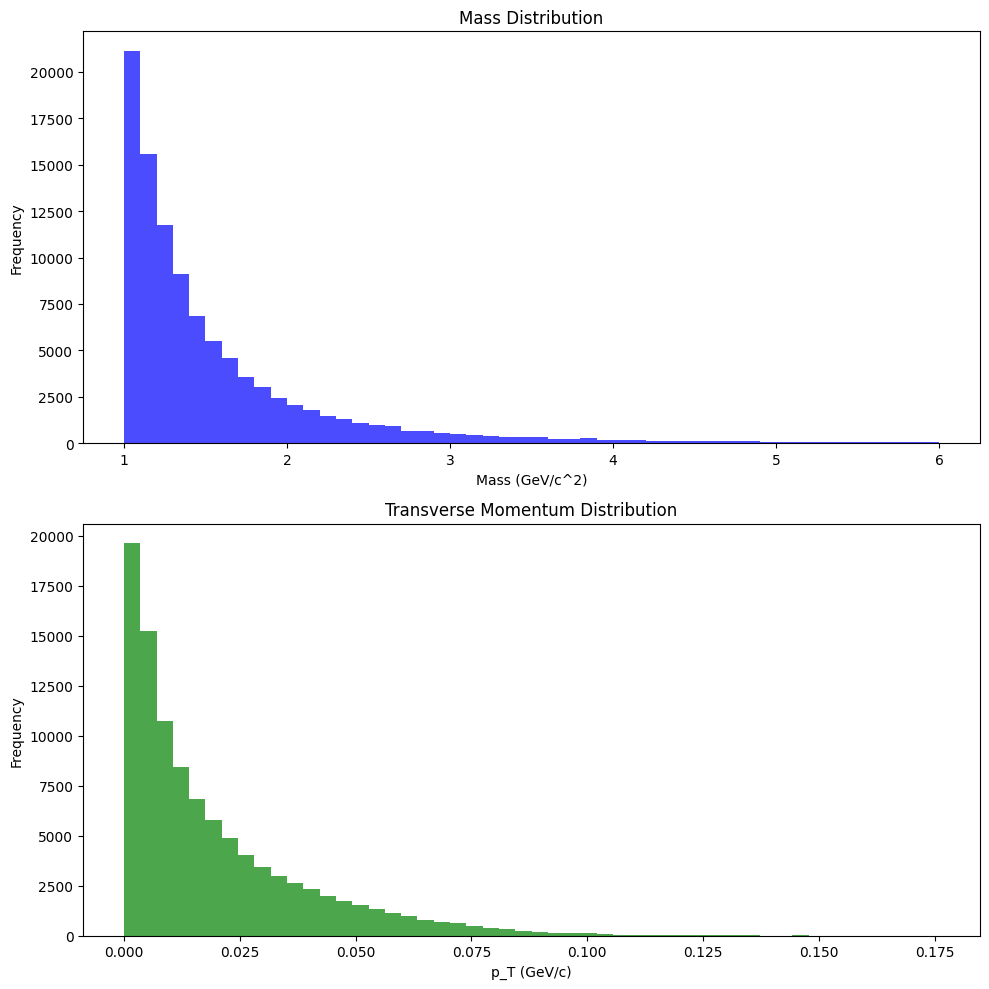

In [5]:
plot_mass_and_pt_distribution(gg_df)

In [6]:
print(daughters_gg_df.head())

   Event Number  Track Number    Energy        px        py        pz
0             1             0  1.266138  0.140385 -0.888044  0.891502
1             1             1  1.338996 -0.138011  0.888194  0.992459
2             2             0  0.521857  0.289636 -0.432667 -0.035278
3             2             1  0.489515 -0.323568  0.364178 -0.047992
4             3             0  0.829362 -0.660527  0.045974 -0.499432


In [7]:
event_df, vertex_df, track_df = parse_starlight_output('slight-phi-ee.out')
grouped_tracks = group_tracks_by_event(track_df)
daughters_df, phi_df = perform_operations_on_event(grouped_tracks)
print(phi_df.head())


                                              mother    Energy        px  \
0  MomentumObject4D(px=-0.004143754936030031, py=...  1.090508 -0.004144   
1  MomentumObject4D(px=0.0012064162009839952, py=...  1.046055  0.001206   
2  MomentumObject4D(px=0.025883832960793995, py=0...  1.032061  0.025884   
3  MomentumObject4D(px=0.02610563303184299, py=0....  1.136266  0.026106   
4  MomentumObject4D(px=-0.066394104308874, py=-0....  1.052234 -0.066394   

         py        pz  
0  0.049471 -0.384927  
1  0.035765 -0.197011  
2  0.006824  0.134575  
3  0.040723 -0.494031  
4 -0.022258 -0.249178  


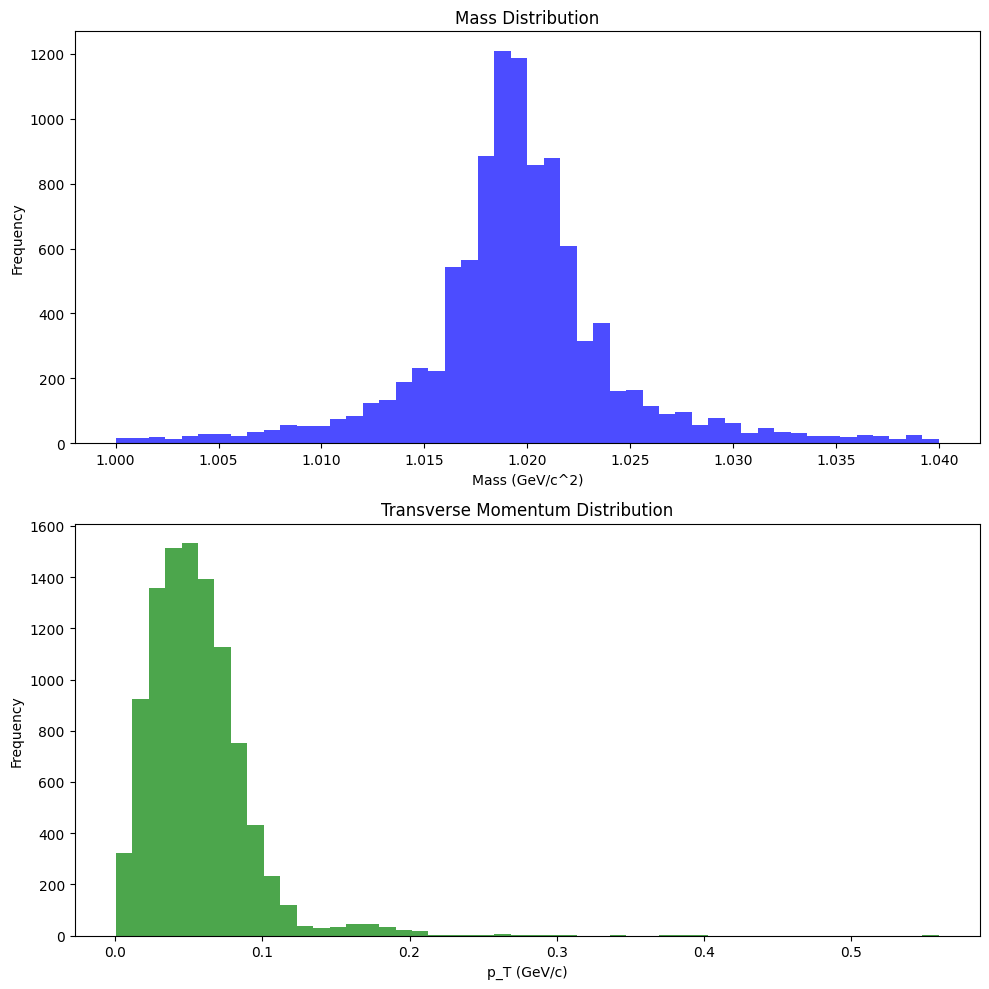

In [8]:
plot_mass_and_pt_distribution(phi_df)

In [9]:
print(daughters_df.head())

   Event Number  Track Number    Energy        px        py        pz
0             1             0  0.563738  0.504080  0.054365 -0.246471
1             1             1  0.526769 -0.508224 -0.004894 -0.138455
2             2             0  0.517686  0.358347  0.373597 -0.003376
3             2             1  0.528369 -0.357141 -0.337831 -0.193635
4             3             0  0.542333 -0.306291 -0.285068  0.345032


#### Checking distributions

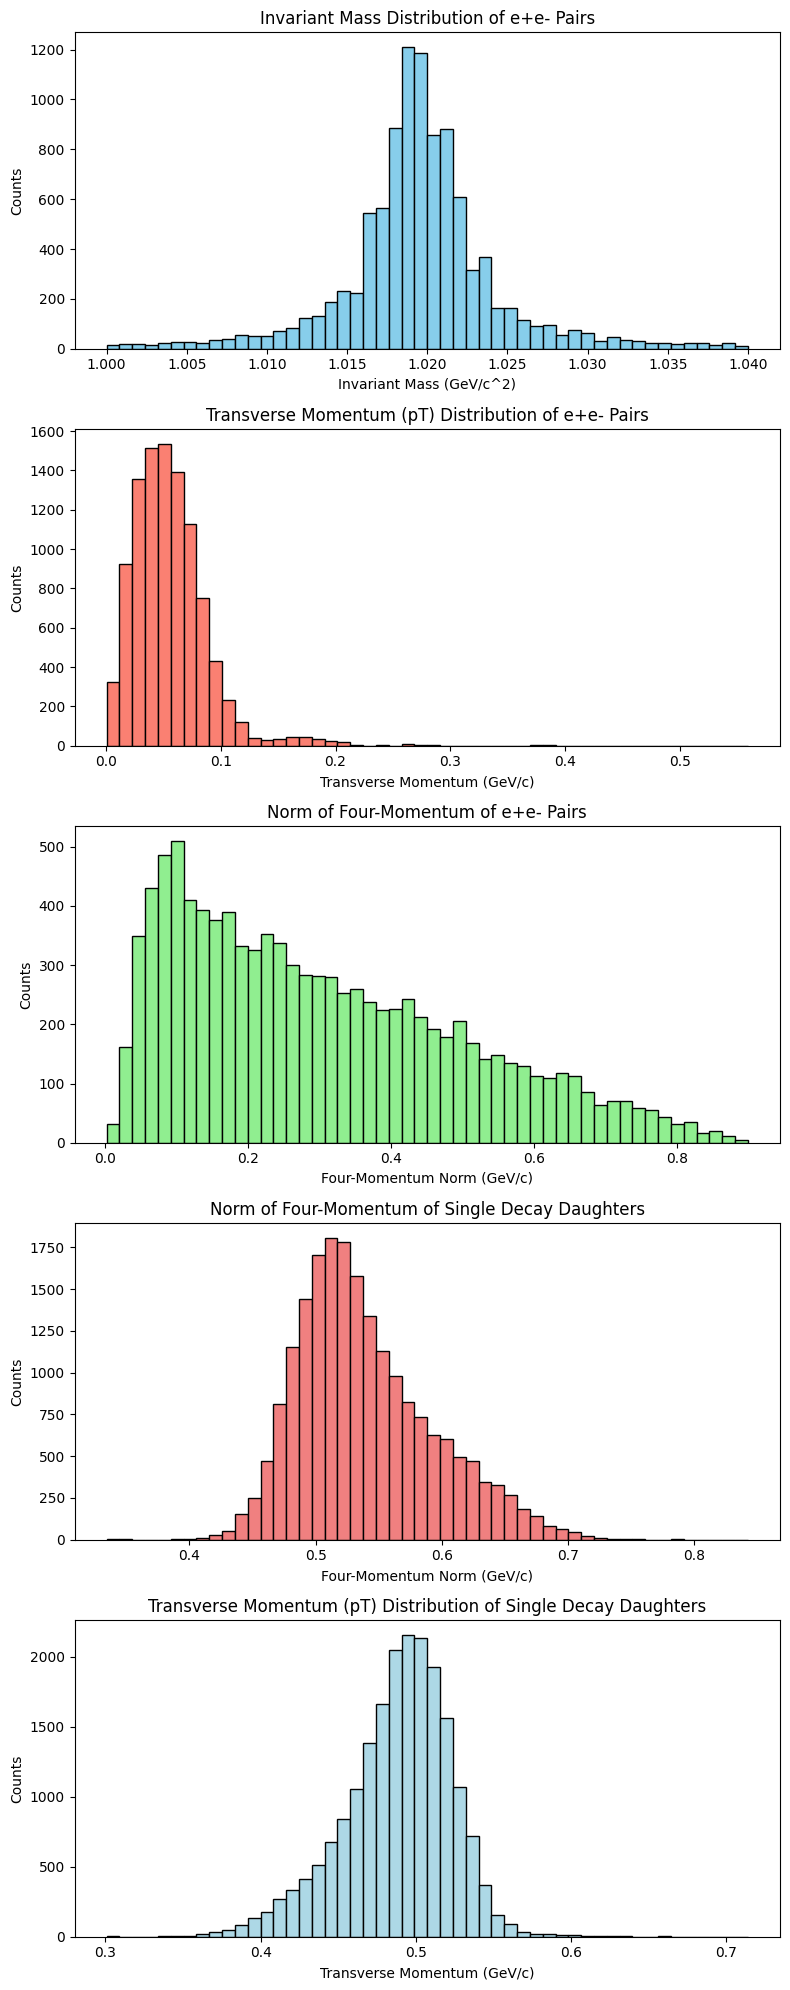

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_distributions_from_daughters(daughters_df):
    """
    Plots invariant mass, transverse momentum, and four-momentum norms of e+e- pairs 
    and single decay daughters based on the input DataFrame.
    
    Parameters:
    daughters_df (pd.DataFrame): DataFrame containing daughter particle information with 
                                 columns ['Event Number', 'Track Number', 'Energy', 'px', 'py', 'pz'].
    """
    # Group by event number to sum electron and positron four-momenta
    grouped = daughters_df.groupby('Event Number')
    
    # Calculate four-momentum components for e+e- pairs
    px_ee = grouped['px'].sum()
    py_ee = grouped['py'].sum()
    pz_ee = grouped['pz'].sum()
    energy_ee = grouped['Energy'].sum()
    
    # Invariant mass of e+e- pairs
    invariant_mass = np.sqrt(energy_ee**2 - (px_ee**2 + py_ee**2 + pz_ee**2))
    
    # Transverse momentum of e+e- pairs
    pt_ee_pairs = np.sqrt(px_ee**2 + py_ee**2)
    
    # Norm of four-momentum of e+e- pairs
    four_momentum_norm_ee_pairs = np.sqrt(px_ee**2 + py_ee**2 + pz_ee**2)
    
    # For single decay daughters
    four_momentum_norm_single = np.sqrt(daughters_df['px']**2 + daughters_df['py']**2 + daughters_df['pz']**2)
    pt_single = np.sqrt(daughters_df['px']**2 + daughters_df['py']**2)

    # Plotting
    fig, axs = plt.subplots(5, 1, figsize=(8, 20))

    axs[0].hist(invariant_mass, bins=50, color='skyblue', edgecolor='black')
    axs[0].set_title("Invariant Mass Distribution of e+e- Pairs")
    axs[0].set_xlabel("Invariant Mass (GeV/c^2)")
    axs[0].set_ylabel("Counts")

    axs[1].hist(pt_ee_pairs, bins=50, color='salmon', edgecolor='black')
    axs[1].set_title("Transverse Momentum (pT) Distribution of e+e- Pairs")
    axs[1].set_xlabel("Transverse Momentum (GeV/c)")
    axs[1].set_ylabel("Counts")

    axs[2].hist(four_momentum_norm_ee_pairs, bins=50, color='lightgreen', edgecolor='black')
    axs[2].set_title("Norm of Four-Momentum of e+e- Pairs")
    axs[2].set_xlabel("Four-Momentum Norm (GeV/c)")
    axs[2].set_ylabel("Counts")

    axs[3].hist(four_momentum_norm_single, bins=50, color='lightcoral', edgecolor='black')
    axs[3].set_title("Norm of Four-Momentum of Single Decay Daughters")
    axs[3].set_xlabel("Four-Momentum Norm (GeV/c)")
    axs[3].set_ylabel("Counts")

    axs[4].hist(pt_single, bins=50, color='lightblue', edgecolor='black')
    axs[4].set_title("Transverse Momentum (pT) Distribution of Single Decay Daughters")
    axs[4].set_xlabel("Transverse Momentum (GeV/c)")
    axs[4].set_ylabel("Counts")

    plt.tight_layout()
    plt.show()

# Example usage:
plot_distributions_from_daughters(daughters_df)


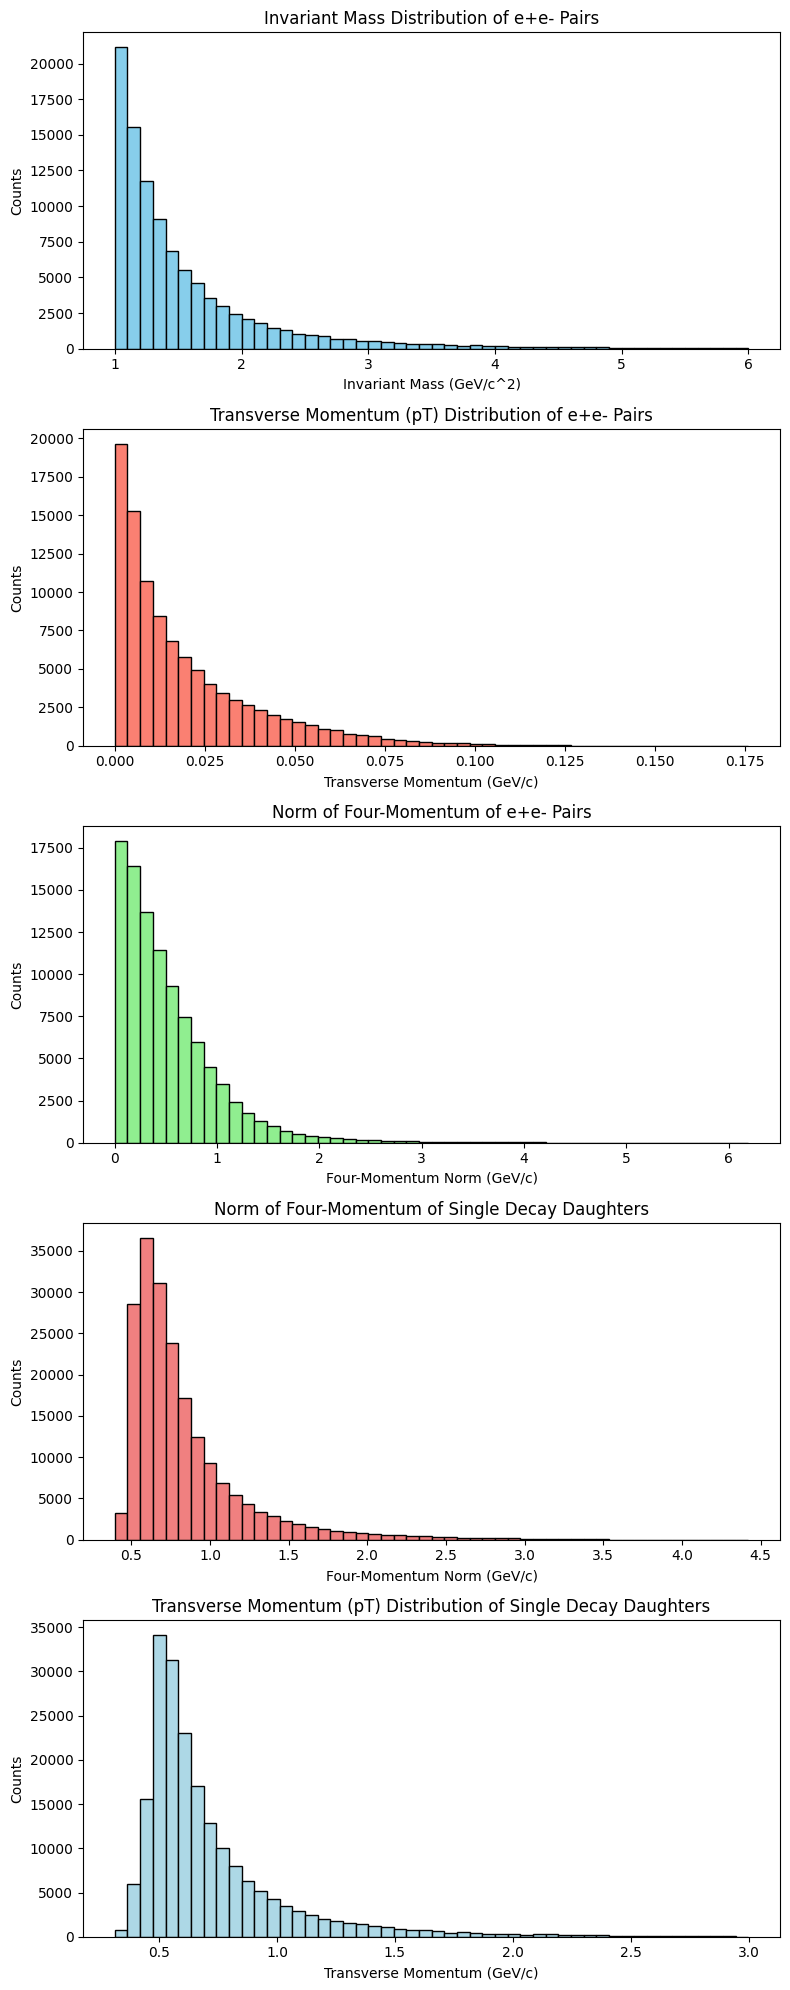

In [11]:
plot_distributions_from_daughters(daughters_gg_df)

### Checking multiple features tht could be fed as input to the ML algorithm

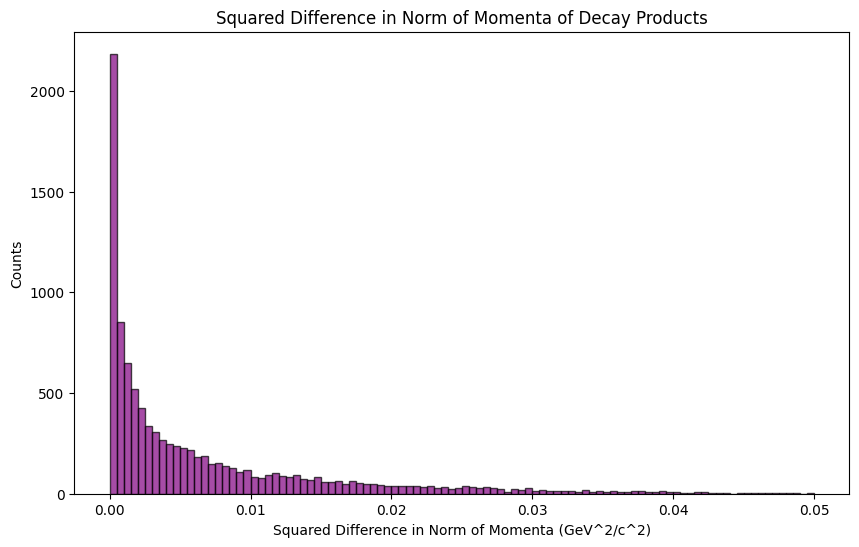

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_squared_momentum_diff(daughters_df):
    """
    Calculates and plots the distribution of the squared difference in norms of the momenta 
    of the two decay products (e+ and e-) in each event.
    
    Parameters:
    daughters_df (pd.DataFrame): DataFrame containing the daughter particle information with 
                                 columns ['Event Number', 'px', 'py', 'pz'].
    """
    # Calculate the norm of the momenta for each decay product
    daughters_df['momentum_norm'] = np.sqrt(daughters_df['px']**2 + daughters_df['py']**2 + daughters_df['pz']**2)
    
    # Group by event and get the norms for e+ and e- in each event
    momentum_norms = daughters_df.groupby('Event Number')['momentum_norm'].apply(list)
    
    # Calculate the squared difference in norms for each event
    squared_diff = [(norms[0] - norms[1])**2 for norms in momentum_norms if len(norms) == 2]
    
    # Plot the distribution with fixed binning
    plt.figure(figsize=(10, 6))
    plt.hist(squared_diff, bins=100, range=(-0.0, 0.05), color='purple', edgecolor='black', alpha=0.7)
    plt.title("Squared Difference in Norm of Momenta of Decay Products")
    plt.xlabel("Squared Difference in Norm of Momenta (GeV^2/c^2)")
    plt.ylabel("Counts")
    plt.show()

# Example usage:
plot_squared_momentum_diff(daughters_df)


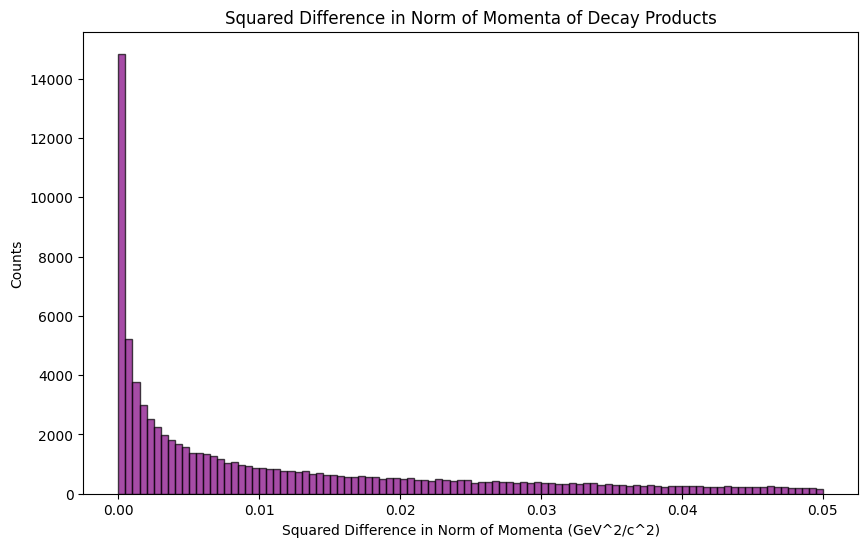

In [13]:
plot_squared_momentum_diff(daughters_gg_df)

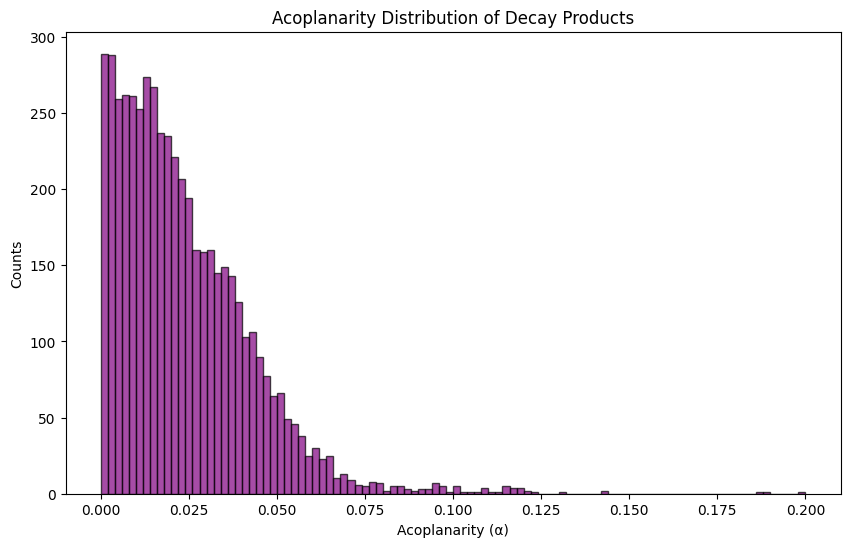

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_and_plot_acoplanarity(daughters_df):
    """
    Calculates and plots the acoplanarity (alpha) for a dataset of decay products.
    
    Parameters:
    daughters_df (pd.DataFrame): DataFrame containing the daughter particle information with 
                                 columns ['Event Number', 'px', 'py'].
    """
    # Calculate the azimuthal angle (phi) for each particle
    daughters_df['phi'] = np.arctan2(daughters_df['py'], daughters_df['px'])
    
    # Group by event and get the azimuthal angles for each event
    phi_angles = daughters_df.groupby('Event Number')['phi'].apply(list)
    
    # Calculate acoplanarity for each event
    acoplanarity = [1 - abs(phis[0] - phis[1]) / np.pi for phis in phi_angles if len(phis) == 2]
    
    # Plot the acoplanarity distribution
    plt.figure(figsize=(10, 6))
    plt.hist(acoplanarity, bins=100, range=(0, 0.2), color='purple', edgecolor='black', alpha=0.7)
    plt.title("Acoplanarity Distribution of Decay Products")
    plt.xlabel("Acoplanarity (α)")
    plt.ylabel("Counts")
    plt.show()

# Example usage:
calculate_and_plot_acoplanarity(daughters_df)


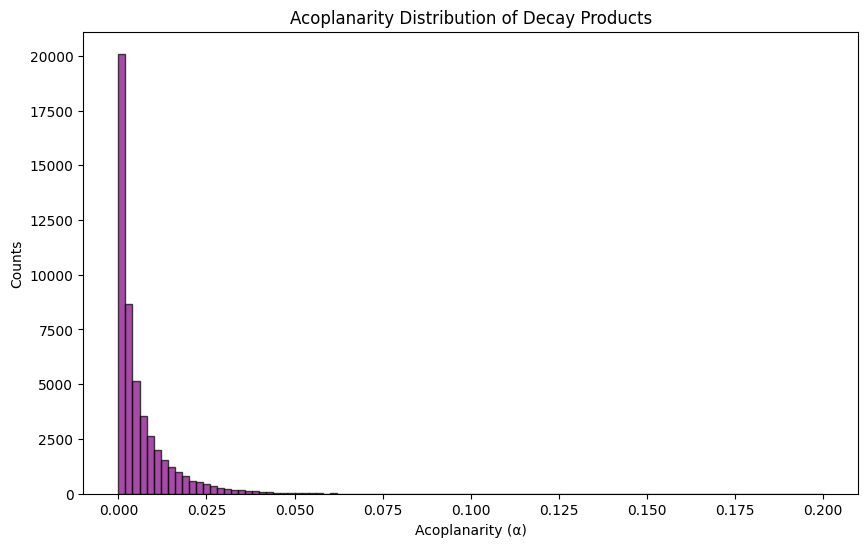

In [15]:
calculate_and_plot_acoplanarity(daughters_gg_df)


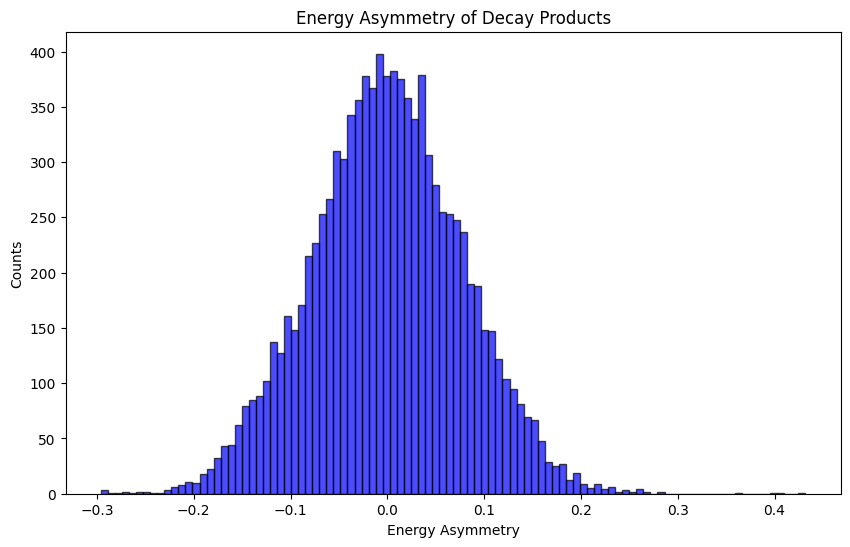

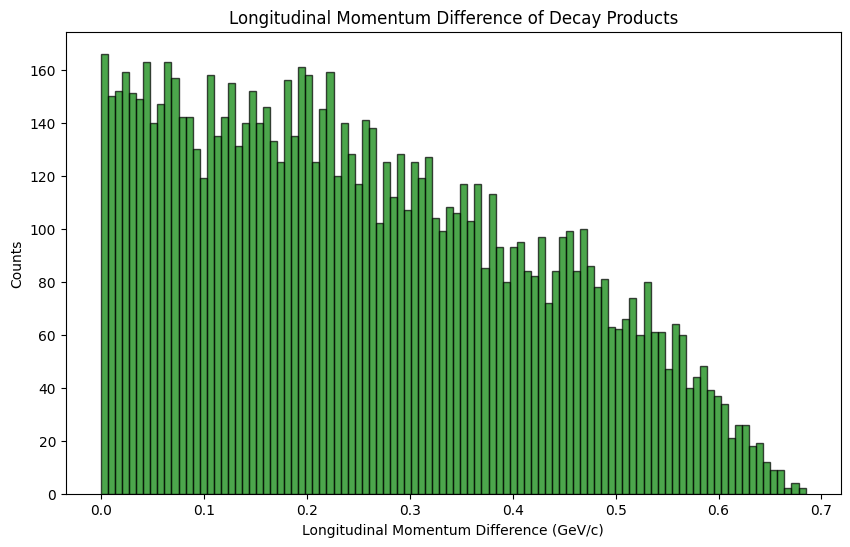

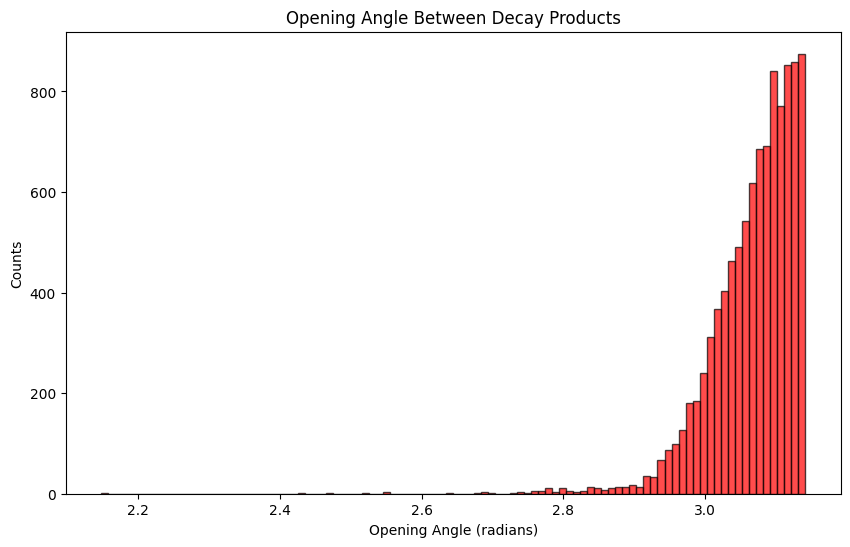

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_and_plot_additional_features(daughters_df):
    """
    Calculates and plots distributions for energy asymmetry, longitudinal momentum difference, 
    and opening angle between decay products.
    
    Parameters:
    daughters_df (pd.DataFrame): DataFrame containing the daughter particle information with 
                                 columns ['Event Number', 'Energy', 'px', 'py', 'pz'].
    """
    # Group by event and get the properties for each particle in each event
    grouped = daughters_df.groupby('Event Number')
    energies = grouped['Energy'].apply(list)
    pz_values = grouped['pz'].apply(list)
    px_values = grouped['px'].apply(list)
    py_values = grouped['py'].apply(list)
    
    # Calculate Energy Asymmetry for each event
    energy_asymmetry = [(e[0] - e[1]) / (e[0] + e[1]) for e in energies if len(e) == 2]
    
    # Calculate Longitudinal Momentum Difference for each event
    longitudinal_momentum_diff = [abs(pz[0] - pz[1]) for pz in pz_values if len(pz) == 2]
    
    # Calculate Opening Angle for each event
    opening_angles = []
    for px, py in zip(px_values, py_values):
        if len(px) == 2 and len(py) == 2:
            p1 = np.array([px[0], py[0]])
            p2 = np.array([px[1], py[1]])
            cos_theta = np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))
            opening_angles.append(np.arccos(cos_theta))

    # Plot Energy Asymmetry
    plt.figure(figsize=(10, 6))
    plt.hist(energy_asymmetry, bins=100, color='blue', edgecolor='black', alpha=0.7)
    plt.title("Energy Asymmetry of Decay Products")
    plt.xlabel("Energy Asymmetry")
    plt.ylabel("Counts")
    plt.show()
    
    # Plot Longitudinal Momentum Difference
    plt.figure(figsize=(10, 6))
    plt.hist(longitudinal_momentum_diff, bins=100, color='green', edgecolor='black', alpha=0.7)
    plt.title("Longitudinal Momentum Difference of Decay Products")
    plt.xlabel("Longitudinal Momentum Difference (GeV/c)")
    plt.ylabel("Counts")
    plt.show()

    # Plot Opening Angle
    plt.figure(figsize=(10, 6))
    plt.hist(opening_angles, bins=100, color='red', edgecolor='black', alpha=0.7)
    plt.title("Opening Angle Between Decay Products")
    plt.xlabel("Opening Angle (radians)")
    plt.ylabel("Counts")
    plt.show()

# Example usage:
calculate_and_plot_additional_features(daughters_df)


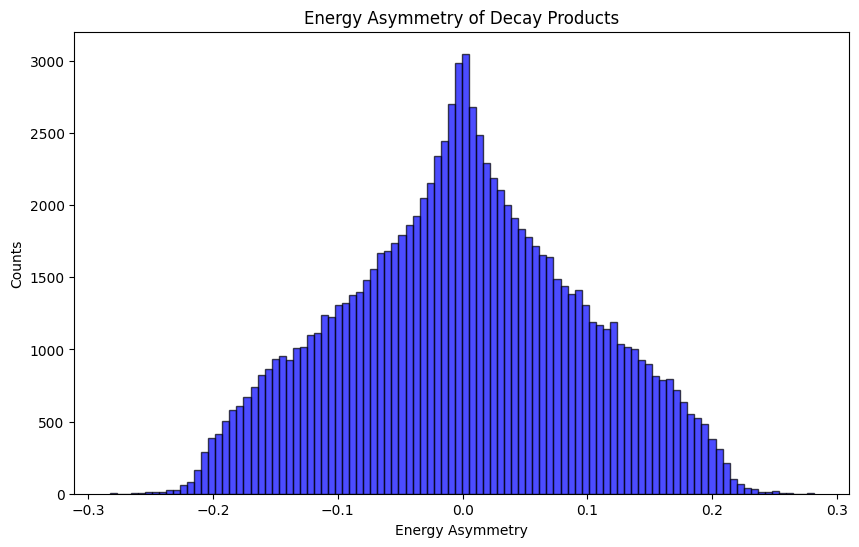

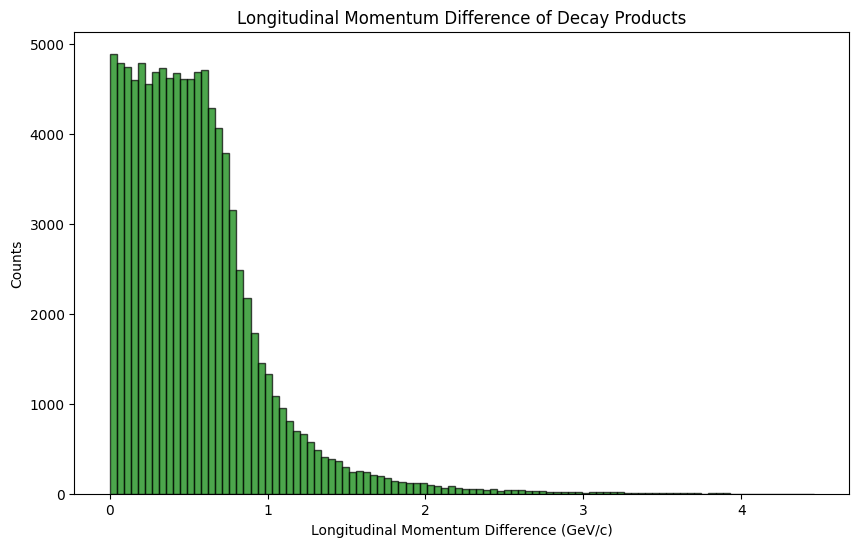

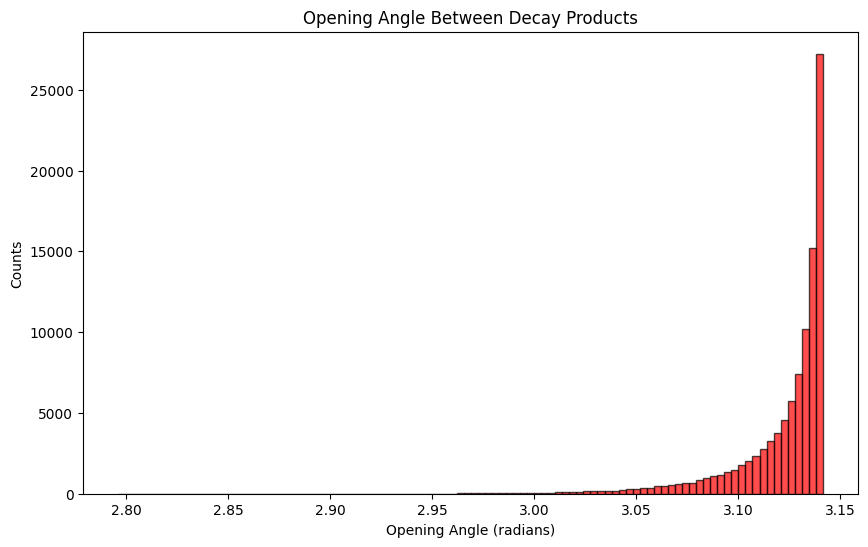

In [17]:
calculate_and_plot_additional_features(daughters_gg_df)


## Feature engineering

In [18]:
import numpy as np

def filter_by_acceptance(daughters_df):
    """
    Filters events based on acceptance criteria:
    - Each track must have pseudorapidity |eta| < 0.8
    - The mother particle (sum of two decay products) must have rapidity |y| < 0.8
    
    Parameters:
    daughters_df (pd.DataFrame): DataFrame containing the daughter particle information with 
                                 columns ['Event Number', 'px', 'py', 'pz', 'Energy'].
    
    Returns:
    pd.DataFrame: Filtered DataFrame with events that meet the acceptance criteria.
    """
    # Calculate pseudorapidity (eta) for each track
    daughters_df['eta'] = 0.5 * np.log((np.sqrt(daughters_df['px']**2 + daughters_df['py']**2 + daughters_df['pz']**2) + daughters_df['pz']) /
                                       (np.sqrt(daughters_df['px']**2 + daughters_df['py']**2 + daughters_df['pz']**2) - daughters_df['pz']))
    
    # Filter tracks based on |eta| < 0.8
    eta_filtered = daughters_df[np.abs(daughters_df['eta']) < 0.8]
    
    # Group by event and calculate the total four-momentum of the mother particle
    grouped = eta_filtered.groupby('Event Number')
    mother_px = grouped['px'].sum()
    mother_py = grouped['py'].sum()
    mother_pz = grouped['pz'].sum()
    mother_energy = grouped['Energy'].sum()
    
    # Calculate rapidity (y) of the mother particle
    mother_rapidity = 0.5 * np.log((mother_energy + mother_pz) / (mother_energy - mother_pz))
    
    # Filter events based on |y| < 0.8 for the mother particle
    accepted_events = mother_rapidity[np.abs(mother_rapidity) < 0.8].index
    filtered_daughters_df = eta_filtered[eta_filtered['Event Number'].isin(accepted_events)]
    
    return filtered_daughters_df

# Example usage:
filtered_daughters_df = filter_by_acceptance(daughters_df)
filtered_daughters_gg_df = filter_by_acceptance(daughters_gg_df)


In [19]:
def compute_features(daughters_df):
    """
    Computes a set of features from the input filtered DataFrame, including:
    - Invariant mass of the e+e- pair
    - Transverse momentum (pT) of the e+e- pair
    - Squared difference in norms of momenta
    - Acoplanarity
    - Energy asymmetry
    - Longitudinal momentum difference
    - Opening angle between decay products
    
    Parameters:
    daughters_df (pd.DataFrame): Filtered DataFrame containing daughter particle information with 
                                 columns ['Event Number', 'px', 'py', 'pz', 'Energy'].
    
    Returns:
    pd.DataFrame: DataFrame containing computed features for each event.
    """
    # Group by event to compute pair-level features
    grouped = daughters_df.groupby('Event Number')
    
    # Initialize lists to collect computed features
    event_numbers = []
    invariant_masses = []
    pt_ee_pairs = []
    squared_momentum_diffs = []
    acoplanarities = []
    energy_asymmetries = []
    longitudinal_momentum_diffs = []
    opening_angles = []
    
    # Loop over each event
    for event_num, group in grouped:
        if len(group) != 2:
            continue  # Only process events with exactly two tracks

        # Extract track-level variables
        px1, py1, pz1, E1 = group.iloc[0][['px', 'py', 'pz', 'Energy']]
        px2, py2, pz2, E2 = group.iloc[1][['px', 'py', 'pz', 'Energy']]
        
        # Event-level variables
        event_numbers.append(event_num)
        
        # 1. Invariant mass of the e+e- pair
        total_energy = E1 + E2
        total_px = px1 + px2
        total_py = py1 + py2
        total_pz = pz1 + pz2
        invariant_mass = np.sqrt(total_energy**2 - total_px**2 - total_py**2 - total_pz**2)
        invariant_masses.append(invariant_mass)
        
        # 2. Transverse momentum (pT) of the e+e- pair
        pt_ee_pairs.append(np.sqrt(total_px**2 + total_py**2))
        
        # 3. Squared difference in norms of momenta
        norm1 = np.sqrt(px1**2 + py1**2 + pz1**2)
        norm2 = np.sqrt(px2**2 + py2**2 + pz2**2)
        squared_momentum_diffs.append((norm1 - norm2)**2)
        
        # 4. Acoplanarity
        phi1 = np.arctan2(py1, px1)
        phi2 = np.arctan2(py2, px2)
        phi_diff = abs(phi1 - phi2)
        phi_diff = min(phi_diff, 2 * np.pi - phi_diff)  # Ensure difference is within [0, π]
        acoplanarity = 1 - phi_diff / np.pi
        acoplanarities.append(acoplanarity)
        
        # 5. Energy asymmetry
        energy_asymmetry = (E1 - E2) / (E1 + E2)
        energy_asymmetries.append(energy_asymmetry)
        
        # 6. Longitudinal momentum difference
        longitudinal_momentum_diffs.append(abs(pz1 - pz2))
        
        # 7. Opening angle between decay products
        p1 = np.array([px1, py1, pz1])
        p2 = np.array([px2, py2, pz2])
        cos_theta = np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))
        opening_angle = np.arccos(cos_theta)
        opening_angles.append(opening_angle)

    # Construct DataFrame with all computed features
    features_df = pd.DataFrame({
        'Event Number': event_numbers,
        'Invariant Mass': invariant_masses,
        'pT (e+e-)': pt_ee_pairs,
        'Squared Momentum Difference': squared_momentum_diffs,
        'Acoplanarity': acoplanarities,
        'Energy Asymmetry': energy_asymmetries,
        'Longitudinal Momentum Difference': longitudinal_momentum_diffs,
        'Opening Angle': opening_angles
    })
    
    return features_df

# filtered_daughters_df = filter_by_acceptance(daughters_df)
features_df = compute_features(filtered_daughters_df)
features_gg_df = compute_features(filtered_daughters_gg_df)


In [20]:
features_df.head()

,Event Number,Invariant Mass,pT (e+e-),Squared Momentum Difference,Acoplanarity,Energy Asymmetry,Longitudinal Momentum Difference,Opening Angle
0,1,1.019105,0.049644,0.001367,0.031132,0.033901,0.108016,2.416859
1,2,1.026712,0.035786,0.000114,0.015473,-0.010213,0.190259,2.756913
2,3,1.022900,0.026768,0.002767,0.009099,0.050971,0.555489,2.895069
3,4,1.022102,0.048372,0.003278,0.021657,-0.050388,0.201350,2.242625
4,5,1.019904,0.070026,0.018480,0.043915,-0.129193,0.464285,2.716208


In [21]:
features_gg_df.head()

,Event Number,Invariant Mass,pT (e+e-),Squared Momentum Difference,Acoplanarity,Energy Asymmetry,Longitudinal Momentum Difference,Opening Angle
0,2,1.005036,0.076434,0.001046,0.043453,0.031978,0.012714,2.926895
1,3,1.634441,0.045710,0.000424,0.009416,0.012576,0.899046,3.009829
2,4,2.696346,0.049396,0.000018,0.008649,0.001532,0.123991,2.683888
3,5,1.386350,0.017144,0.020675,0.001141,0.098929,0.427441,2.563553
4,7,1.108427,0.016459,0.000012,0.008464,-0.003088,0.092793,3.051142


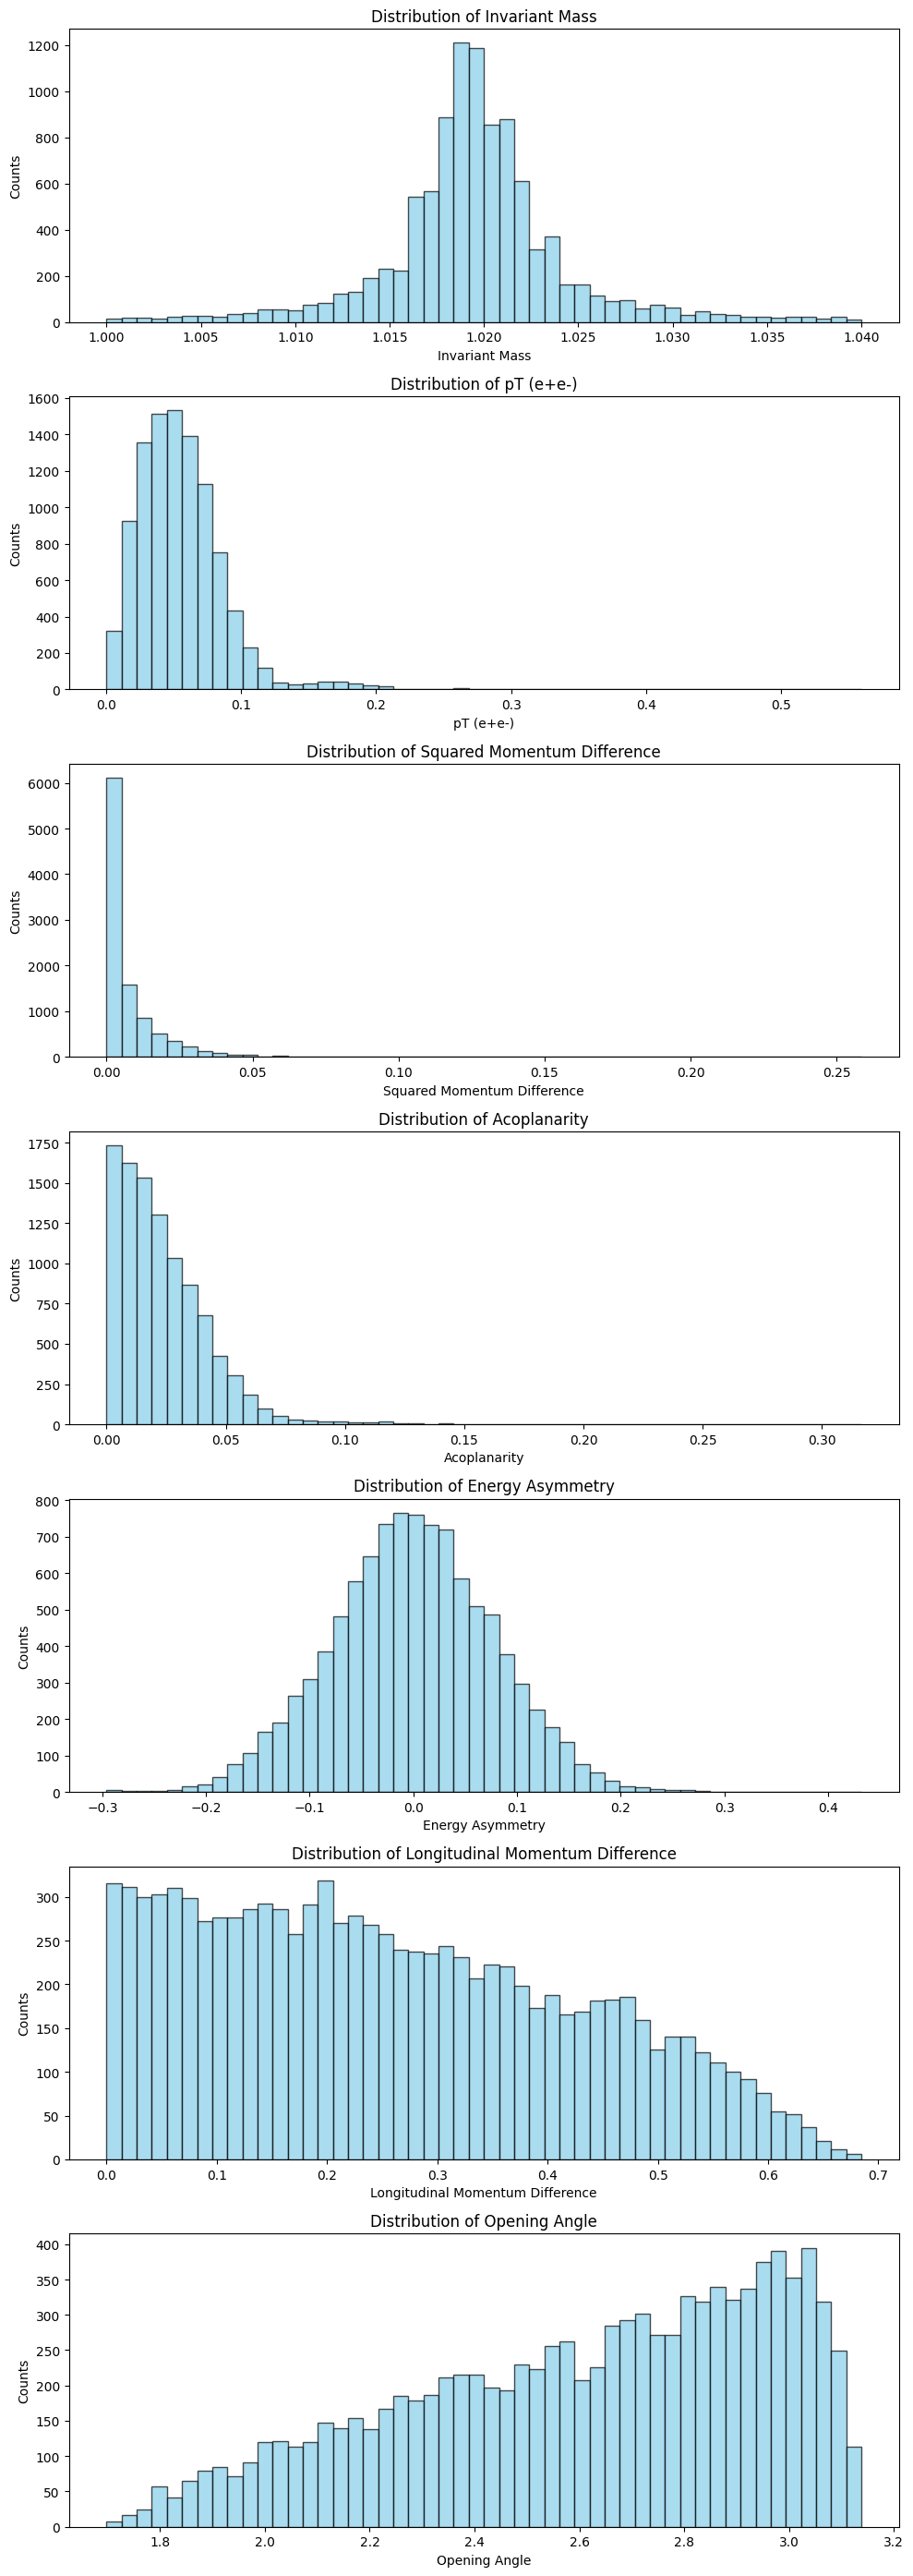

In [22]:
import matplotlib.pyplot as plt

def plot_features(features_df):
    """
    Plots histograms for each feature in the features DataFrame.
    
    Parameters:
    features_df (pd.DataFrame): DataFrame containing computed features for each event.
    """
    # Set up a figure with subplots for each feature
    n_features = features_df.shape[1] - 1  # Exclude the 'Event Number' column
    fig, axs = plt.subplots(n_features, 1, figsize=(10, 4 * n_features))
    
    # Plot each feature in a separate subplot
    for i, col in enumerate(features_df.columns[1:]):  # Skip 'Event Number' column
        axs[i].hist(features_df[col], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
        axs[i].set_title(f"Distribution of {col}")
        axs[i].set_xlabel(col)
        axs[i].set_ylabel("Counts")
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_features(features_df)


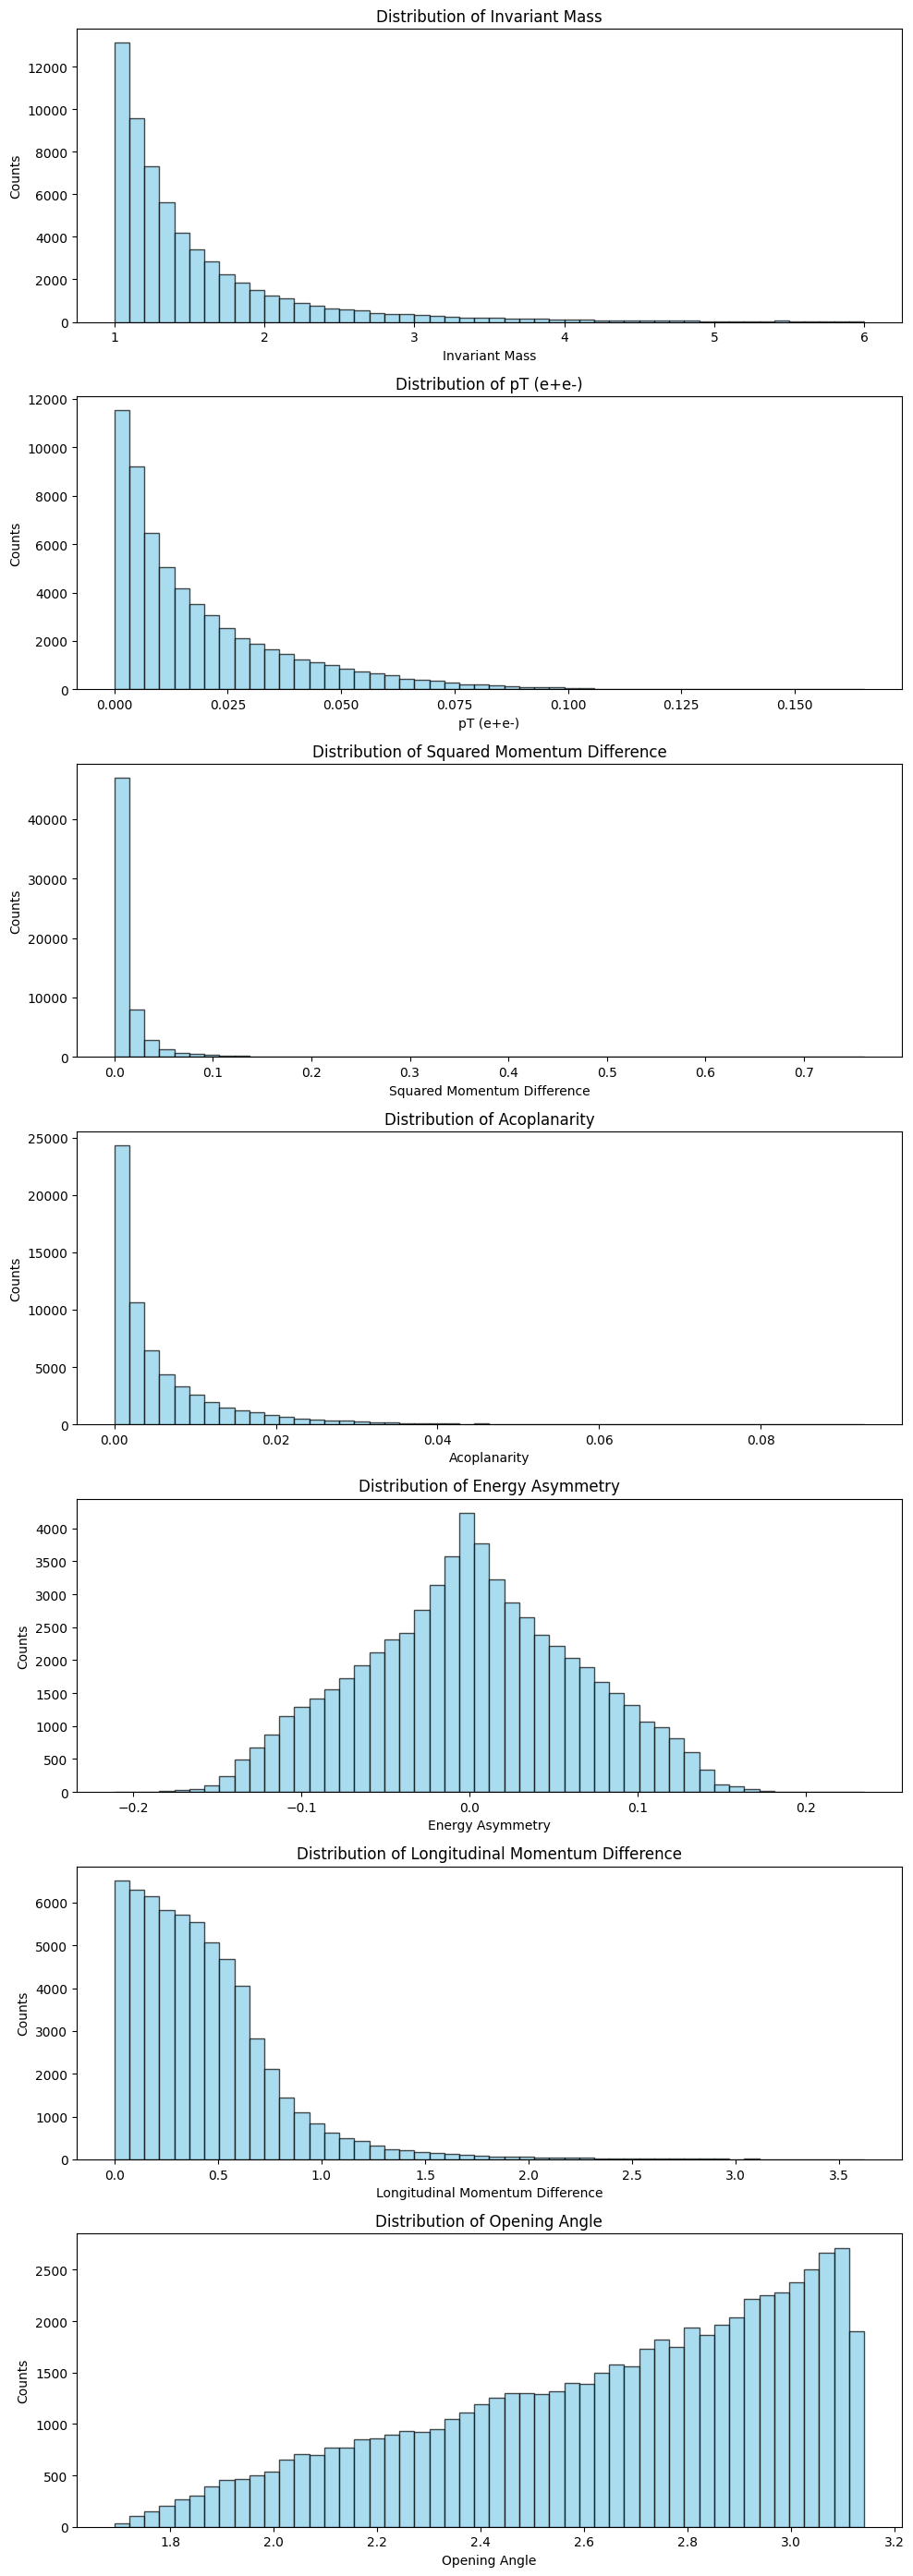

In [23]:
plot_features(features_gg_df)


### Random forest

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

def prepare_data(phi_features_df, photon_features_df):
    """
    Prepares the combined dataset with labels.
    - phi_features_df: DataFrame with features for phi -> e+ e- events (signal, label 1)
    - photon_features_df: DataFrame with features for photon-photon -> e+ e- events (background, label 0)
    
    Returns:
    X, y: Feature matrix and labels
    """
    # Assign labels
    phi_features_df['Label'] = 1  # Signal
    photon_features_df['Label'] = 0  # Background
    
    # Combine datasets
    combined_df = pd.concat([phi_features_df, photon_features_df], ignore_index=True)
    
    # Separate features and labels
    X = combined_df.drop(columns=['Event Number', 'Label'])  # Drop non-feature columns
    y = combined_df['Label']
    
    return X, y

def train_random_forest(X, y):
    """
    Trains a Random Forest classifier on the given data and evaluates its performance.
    
    Parameters:
    X (pd.DataFrame): Feature matrix
    y (pd.Series): Labels
    
    Returns:
    model: Trained Random Forest model
    """
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Initialize the Random Forest classifier
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    
    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"Accuracy: {accuracy:.3f}")
    print(f"ROC-AUC: {roc_auc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Feature importance
    feature_importances = rf_model.feature_importances_
    feature_names = X.columns
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, feature_importances, color='skyblue')
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()
    
    return rf_model

# Example usage:
X, y = prepare_data(features_df, features_gg_df)
# rf_model = train_random_forest(X, y)


### Now selecting only the right invariant mass region

In [25]:
def prepare_filter_mass_range_data(phi_features_df, photon_features_df, mass_min=1.0, mass_max=1.04):
    """
    Prepares the combined dataset with labels.
    - phi_features_df: DataFrame with features for phi -> e+ e- events (signal, label 1)
    - photon_features_df: DataFrame with features for photon-photon -> e+ e- events (background, label 0)
    
    Returns:
    X, y: Feature matrix and labels
    """
    # Assign labels
    phi_features_df['Label'] = 1  # Signal
    photon_features_df['Label'] = 0  # Background
    
    # Combine datasets
    filtered_df = photon_features_df[(photon_features_df['Invariant Mass'] >= mass_min) & (photon_features_df['Invariant Mass'] <= mass_max)]
    combined_df = pd.concat([phi_features_df, filtered_df], ignore_index=True)
    
    # Separate features and labels
    X = combined_df.drop(columns=['Event Number', 'Invariant Mass', 'Label'])  # Drop non-feature columns
    y = combined_df['Label']
    
    return X, y

X_filtered, y_filtered = prepare_filter_mass_range_data(features_df, features_gg_df)
# rf_model_filtered = train_random_forest(X_filtered, y_filtered)

In [26]:
X_filtered.head()

,pT (e+e-),Squared Momentum Difference,Acoplanarity,Energy Asymmetry,Longitudinal Momentum Difference,Opening Angle
0,0.049644,0.001367,0.031132,0.033901,0.108016,2.416859
1,0.035786,0.000114,0.015473,-0.010213,0.190259,2.756913
2,0.026768,0.002767,0.009099,0.050971,0.555489,2.895069
3,0.048372,0.003278,0.021657,-0.050388,0.201350,2.242625
4,0.070026,0.018480,0.043915,-0.129193,0.464285,2.716208


Accuracy: 0.813
ROC-AUC: 0.860

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.67      0.72      1715
           1       0.83      0.89      0.86      3023

    accuracy                           0.81      4738
   macro avg       0.80      0.78      0.79      4738
weighted avg       0.81      0.81      0.81      4738



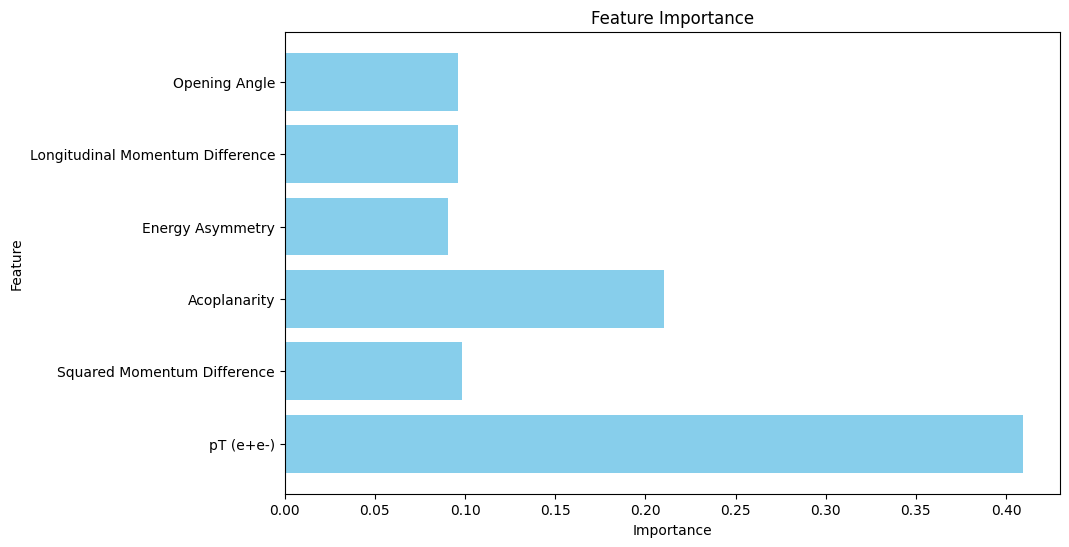

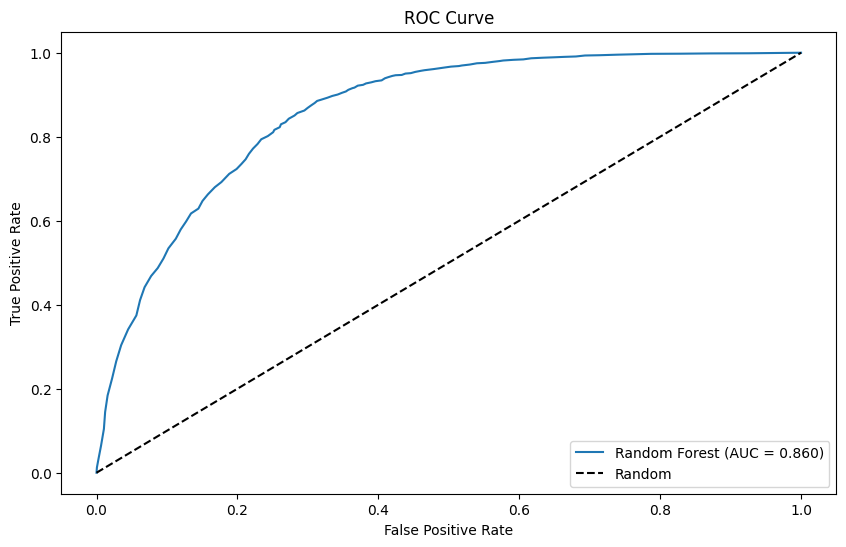

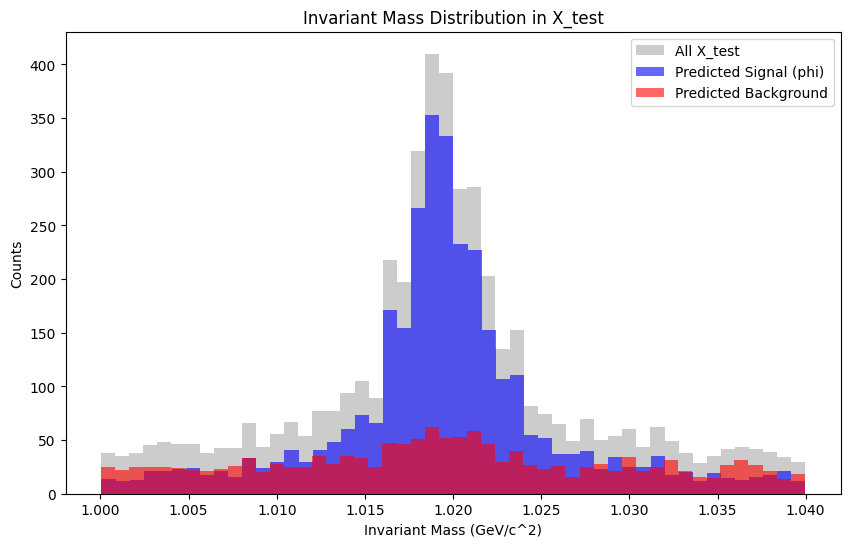

In [27]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt

def prepare_filter_mass_range_data(phi_features_df, photon_features_df, mass_min=1.0, mass_max=1.04):
    """
    Prepares the combined dataset with labels.
    - phi_features_df: DataFrame with features for phi -> e+ e- events (signal, label 1)
    - photon_features_df: DataFrame with features for photon-photon -> e+ e- events (background, label 0)
    
    Returns:
    X, y: Feature matrix and labels
    """
    # Assign labels
    phi_features_df['Label'] = 1  # Signal
    photon_features_df['Label'] = 0  # Background
    
    # Filter photon background by invariant mass range
    filtered_df = photon_features_df[(photon_features_df['Invariant Mass'] >= mass_min) & (photon_features_df['Invariant Mass'] <= mass_max)]
    
    # Combine datasets
    combined_df = pd.concat([phi_features_df, filtered_df], ignore_index=True)
    
    # Separate features and labels
    X = combined_df.drop(columns=['Event Number', 'Label'])  # Drop non-feature columns but keep 'Invariant Mass' for plotting
    y = combined_df['Label']
    
    return X, y

def train_random_forest(phi_features_df, photon_features_df, mass_min=1.0, mass_max=1.04):
    """
    Trains a Random Forest classifier on the given data and evaluates its performance.
    
    Parameters:
    phi_features_df (pd.DataFrame): DataFrame with features for phi -> e+ e- events (signal, label 1)
    photon_features_df (pd.DataFrame): DataFrame with features for photon-photon -> e+ e- events (background, label 0)
    mass_min (float): Minimum invariant mass for filtering background events
    mass_max (float): Maximum invariant mass for filtering background events
    
    Returns:
    model: Trained Random Forest model
    """
    # Prepare data with filtering
    X, y = prepare_filter_mass_range_data(phi_features_df, photon_features_df, mass_min, mass_max)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['Invariant Mass']), y, test_size=0.3, random_state=42)
    
    # Initialize the Random Forest classifier
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    
    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"Accuracy: {accuracy:.3f}")
    print(f"ROC-AUC: {roc_auc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Feature importance
    feature_importances = rf_model.feature_importances_
    feature_names = X_train.columns
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, feature_importances, color='skyblue')
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    # Plot invariant mass distributions
    fig, ax = plt.subplots(figsize=(10, 6))

    # Overall invariant mass distribution in X_test
    invariant_mass_test = X_test.join(X[['Invariant Mass']])
    ax.hist(invariant_mass_test['Invariant Mass'], bins=50, color='gray', alpha=0.4, label='All X_test')

    # Signal (phi) invariant mass distribution in X_test
    signal_mask = (y_pred == 1)  # Assuming label 1 is for the phi signal
    ax.hist(invariant_mass_test[signal_mask]['Invariant Mass'], bins=50, color='blue', alpha=0.6, label='Predicted Signal (phi)')

    # Background invariant mass distribution in X_test
    background_mask = (y_pred == 0)  # Assuming label 0 is for the background
    ax.hist(invariant_mass_test[background_mask]['Invariant Mass'], bins=50, color='red', alpha=0.6, label='Predicted Background')

    # Labels and legend
    ax.set_title("Invariant Mass Distribution in X_test")
    ax.set_xlabel("Invariant Mass (GeV/c^2)")
    ax.set_ylabel("Counts")
    ax.legend(loc="upper right")

    plt.show()
    
    return rf_model

# Example usage:
rf_model_filtered = train_random_forest(features_df, features_gg_df)


Accuracy: 0.813
ROC-AUC: 0.860

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.67      0.72      1715
           1       0.83      0.89      0.86      3023

    accuracy                           0.81      4738
   macro avg       0.80      0.78      0.79      4738
weighted avg       0.81      0.81      0.81      4738



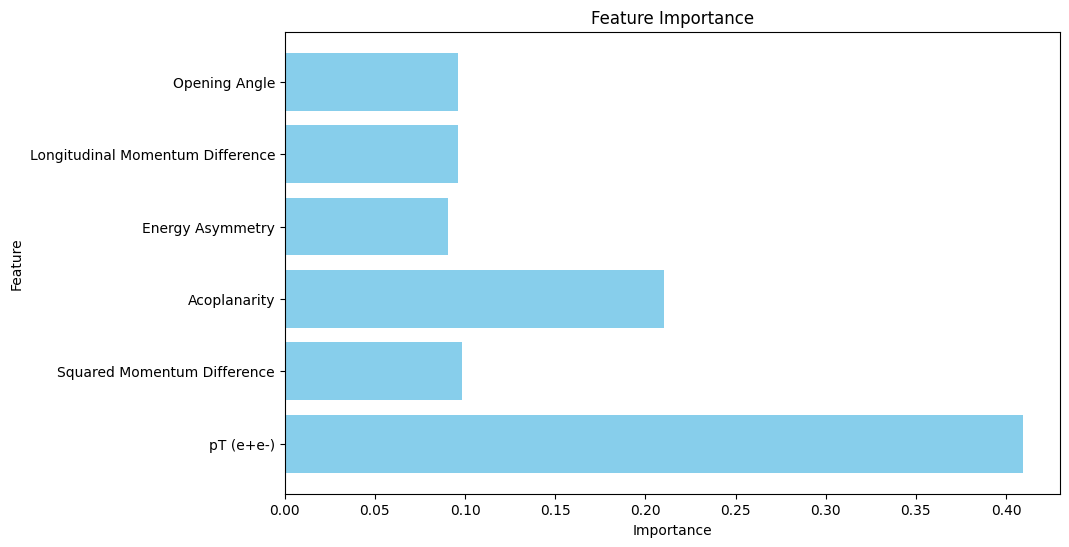

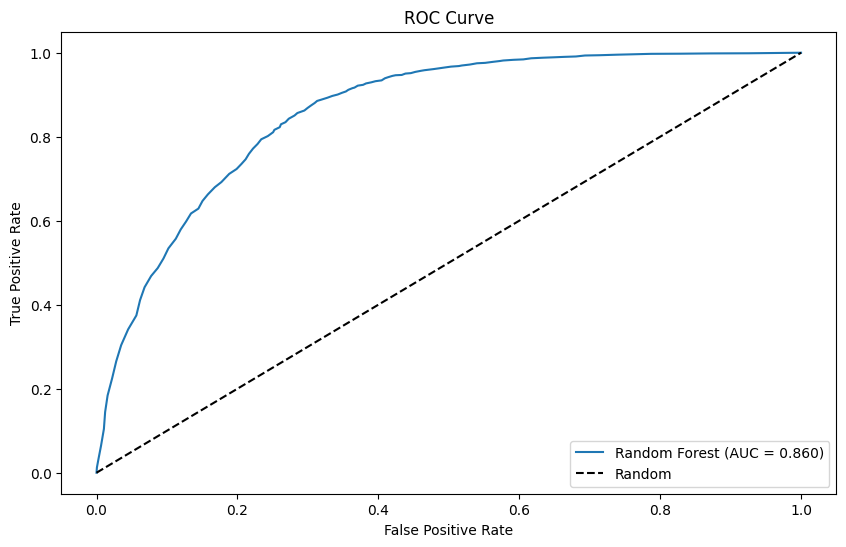

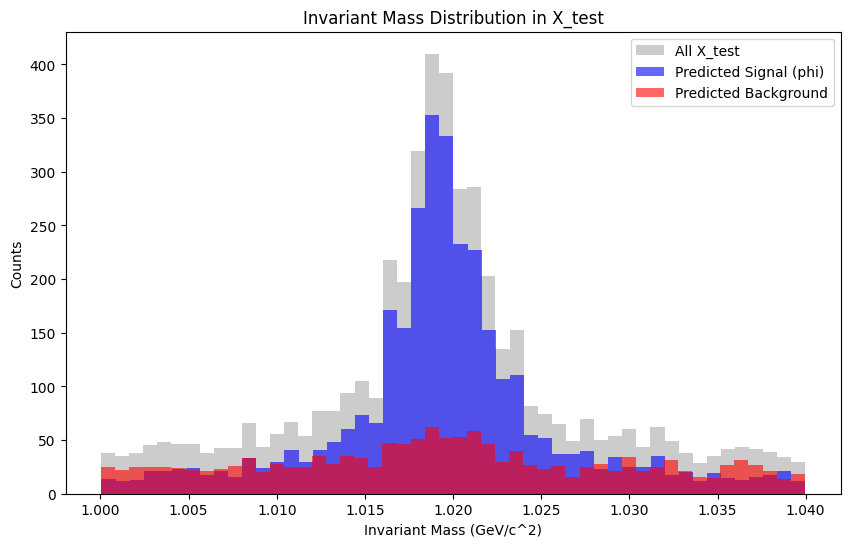

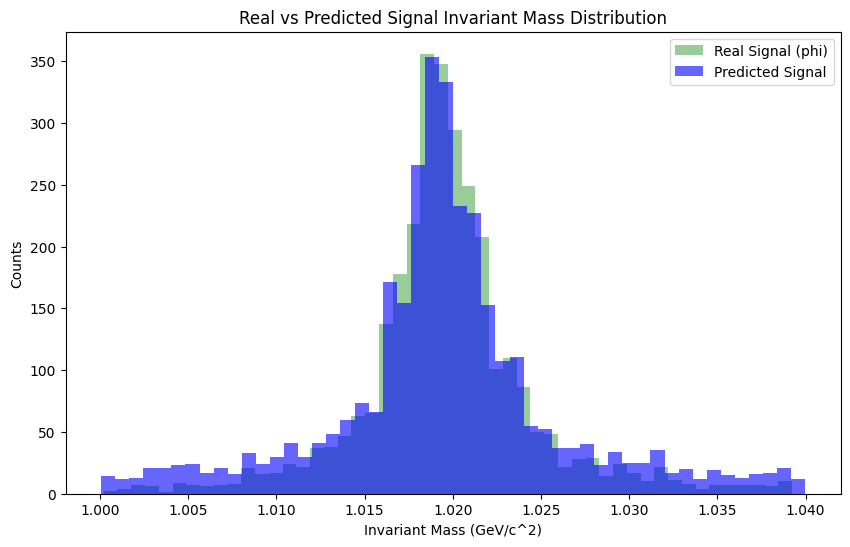

In [28]:
def train_random_forest(phi_features_df, photon_features_df, mass_min=1.0, mass_max=1.04):
    """
    Trains a Random Forest classifier on the given data and evaluates its performance.
    
    Parameters:
    phi_features_df (pd.DataFrame): DataFrame with features for phi -> e+ e- events (signal, label 1)
    photon_features_df (pd.DataFrame): DataFrame with features for photon-photon -> e+ e- events (background, label 0)
    mass_min (float): Minimum invariant mass for filtering background events
    mass_max (float): Maximum invariant mass for filtering background events
    
    Returns:
    model: Trained Random Forest model
    """
    # Prepare data with filtering
    X, y = prepare_filter_mass_range_data(phi_features_df, photon_features_df, mass_min, mass_max)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['Invariant Mass']), y, test_size=0.3, random_state=42)
    
    # Initialize the Random Forest classifier
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    
    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"Accuracy: {accuracy:.3f}")
    print(f"ROC-AUC: {roc_auc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Feature importance
    feature_importances = rf_model.feature_importances_
    feature_names = X_train.columns
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, feature_importances, color='skyblue')
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.savefig("features.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.savefig("roc.pdf", format="pdf", bbox_inches="tight")
    plt.show()

    # Plot invariant mass distributions
    fig, ax = plt.subplots(figsize=(10, 6))

    # Overall invariant mass distribution in X_test
    invariant_mass_test = X_test.join(X[['Invariant Mass']])
    ax.hist(invariant_mass_test['Invariant Mass'], bins=50, color='gray', alpha=0.4, label='All X_test')

    # Signal (phi) invariant mass distribution in X_test
    signal_mask = (y_pred == 1)  # Assuming label 1 is for the phi signal
    ax.hist(invariant_mass_test[signal_mask]['Invariant Mass'], bins=50, color='blue', alpha=0.6, label='Predicted Signal (phi)')

    # Background invariant mass distribution in X_test
    background_mask = (y_pred == 0)  # Assuming label 0 is for the background
    ax.hist(invariant_mass_test[background_mask]['Invariant Mass'], bins=50, color='red', alpha=0.6, label='Predicted Background')

    # Labels and legend
    ax.set_title("Invariant Mass Distribution in X_test")
    ax.set_xlabel("Invariant Mass (GeV/c^2)")
    ax.set_ylabel("Counts")
    ax.legend(loc="upper right")

    plt.savefig("inv-mass.pdf", format="pdf", bbox_inches="tight")
    plt.show()

    # Additional plot: Real vs Predicted Signal
    fig, ax = plt.subplots(figsize=(10, 6))

    # Real signal events (true phi events)
    real_signal_mask = (y_test == 1)
    ax.hist(invariant_mass_test[real_signal_mask]['Invariant Mass'], bins=50, color='green', alpha=0.4, label='Real Signal (phi)')

    # Predicted signal events (events classified as signal by model)
    predicted_signal_mask = (y_pred == 1)
    ax.hist(invariant_mass_test[predicted_signal_mask]['Invariant Mass'], bins=50, color='blue', alpha=0.6, label='Predicted Signal')

    # Labels and legend
    ax.set_title("Real vs Predicted Signal Invariant Mass Distribution")
    ax.set_xlabel("Invariant Mass (GeV/c^2)")
    ax.set_ylabel("Counts")
    ax.legend(loc="upper right")

    plt.show()
    
    return rf_model

# Example usage:
rf_model_filtered = train_random_forest(features_df, features_gg_df)


## Using ALICE data 

Keys in the ROOT file: ['DF_2338571178859232;1', 'DF_2338571178859232/O2tree;1', 'parentFiles;1']
Branches in the tree: ['fPX1', 'fPY1', 'fPZ1', 'fPE1', 'fPX2', 'fPY2', 'fPZ2', 'fPE2', 'fNCOUNTERPV', 'fNELECTRONSTOF']
       fPX1      fPY1      fPZ1      fPE1      fPX2      fPY2      fPZ2  \
0  0.050540  0.404537 -0.064421  0.412741 -0.088783 -0.431698 -0.139300   
1 -0.335205  0.144857  0.076276  0.373047  0.295266 -0.151080 -0.078077   
2  0.118832 -0.423216  0.121064  0.455949 -0.146964  0.390501 -0.346158   
3  0.385823  0.173934 -0.310857  0.525114 -0.311763 -0.139292  0.113268   
4 -0.262443 -0.332744 -0.300193  0.519337 -0.458067 -0.146581 -0.300945   

       fPE2  fNCOUNTERPV  fNELECTRONSTOF  
0  0.462223            2               0  
1  0.340739            2               0  
2  0.542139            2               1  
3  0.359762            2               0  
4  0.567344            4               0  


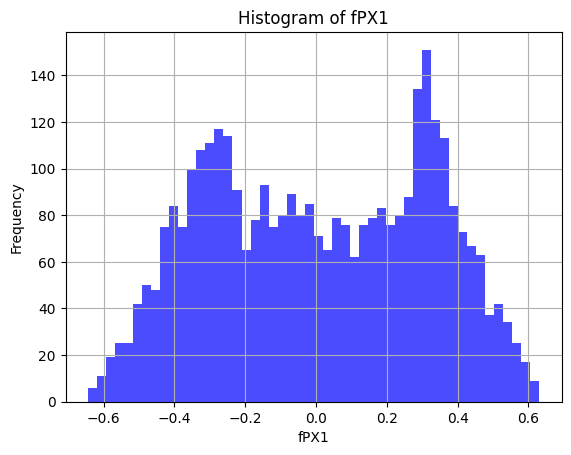

In [32]:
import uproot

# Path to the ROOT file
root_file_path = "AO2D.root"

# Open the ROOT file
file = uproot.open(root_file_path)

# List all the keys (trees, histograms, etc.) in the file
print("Keys in the ROOT file:", file.keys())

# Access a specific tree by its name (replace 'tree_name' with the actual tree name)
tree_name = "DF_2338571178859232/O2tree"  # Replace with your tree name
tree = file[tree_name]

# Print the list of branches in the tree
print("Branches in the tree:", tree.keys())

# Convert the tree into a Pandas DataFrame for easy manipulation
# Replace 'branch1', 'branch2', ... with the branches you want to load
branches_to_load = ["fPX1", "fPY1", "fPZ1", "fPE1", "fPX2", "fPY2", "fPZ2", "fPE2", "fNCOUNTERPV", "fNELECTRONSTOF"]  # Replace with actual branch names
df = tree.arrays(branches_to_load, library="pd")

# Display the first few rows of the DataFrame
print(df.head())

# Example: Plot a histogram of a branch
import matplotlib.pyplot as plt
branch_to_plot = "fPX1"  # Replace with the branch you want to plot
plt.hist(df[branch_to_plot], bins=50, color="blue", alpha=0.7)
plt.xlabel(branch_to_plot)
plt.ylabel("Frequency")
plt.title(f"Histogram of {branch_to_plot}")
plt.grid(True)
plt.show()


In [33]:
df.head()

,fPX1,fPY1,fPZ1,fPE1,fPX2,fPY2,fPZ2,fPE2,fNCOUNTERPV,fNELECTRONSTOF
0,0.050540,0.404537,-0.064421,0.412741,-0.088783,-0.431698,-0.139300,0.462223,2,0
1,-0.335205,0.144857,0.076276,0.373047,0.295266,-0.151080,-0.078077,0.340739,2,0
2,0.118832,-0.423216,0.121064,0.455949,-0.146964,0.390501,-0.346158,0.542139,2,1
3,0.385823,0.173934,-0.310857,0.525114,-0.311763,-0.139292,0.113268,0.359762,2,0
4,-0.262443,-0.332744,-0.300193,0.519337,-0.458067,-0.146581,-0.300945,0.567344,4,0


In [40]:
# Print the feature names used during training
print("Feature names used during training:")
print(rf_model_filtered.feature_names_in_)


Feature names used during training:
['pT (e+e-)' 'Squared Momentum Difference' 'Acoplanarity'
 'Energy Asymmetry' 'Longitudinal Momentum Difference' 'Opening Angle']


In [41]:
def prepare_model_input(df, trained_model):
    """
    Prepares the input DataFrame for running through the trained model and splits it into subsets.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing the branches from the ROOT file.
    trained_model: Pre-trained model (e.g., Random Forest).
    
    Returns:
    prepared_dfs (dict): Dictionary containing DataFrames for fNELECTRONSTOF values of 0, 1, and 2.
    predictions (dict): Dictionary containing model predictions for each subset.
    """
    # Add 'Opening Angle' calculation
    dot_product = df["fPX1"] * df["fPX2"] + df["fPY1"] * df["fPY2"] + df["fPZ1"] * df["fPZ2"]
    magnitude1 = np.sqrt(df["fPX1"]**2 + df["fPY1"]**2 + df["fPZ1"]**2)
    magnitude2 = np.sqrt(df["fPX2"]**2 + df["fPY2"]**2 + df["fPZ2"]**2)
    df["Opening Angle"] = np.arccos(dot_product / (magnitude1 * magnitude2))
    df["Longitudinal Momentum Difference"] = abs(df["fPZ1"] - df["fPZ2"])
    df["Energy Asymmetry"] = (df["fPE1"] - df["fPE2"]) / (df["fPE1"] + df["fPE2"])
    phi1 = np.arctan2(df["fPY1"], df["fPX1"])
    phi2 = np.arctan2(df["fPY2"], df["fPX2"])
    df["Acoplanarity"] = 1 - np.abs(phi1 - phi2) / np.pi
    df["Squared Momentum Difference"] = ((df["fPX1"] - df["fPX2"])**2 + 
                                          (df["fPY1"] - df["fPY2"])**2 + 
                                          (df["fPZ1"] - df["fPZ2"])**2)
    df["pT (e+e-)"] = ((df["fPX1"] + df["fPX2"])**2 + (df["fPY1"] + df["fPY2"])**2)**0.5


    # # Feature engineering: calculate necessary features for the model
    # df["pT (e+e-)"] = ((df["fPX1"] + df["fPX2"])**2 + (df["fPY1"] + df["fPY2"])**2)**0.5
    # df["Energy Asymmetry"] = (df["fPE1"] - df["fPE2"]) / (df["fPE1"] + df["fPE2"])
    # df["Squared Momentum Difference"] = ((df["fPX1"] - df["fPX2"])**2 + 
    #                                       (df["fPY1"] - df["fPY2"])**2 + 
    #                                       (df["fPZ1"] - df["fPZ2"])**2)
    # phi1 = np.arctan2(df["fPY1"], df["fPX1"])
    # phi2 = np.arctan2(df["fPY2"], df["fPX2"])
    # df["Acoplanarity"] = 1 - np.abs(phi1 - phi2) / np.pi
    # df["Longitudinal Momentum Difference"] = abs(df["fPZ1"] - df["fPZ2"])
    
    # # Add 'Opening Angle' calculation
    # dot_product = df["fPX1"] * df["fPX2"] + df["fPY1"] * df["fPY2"] + df["fPZ1"] * df["fPZ2"]
    # magnitude1 = np.sqrt(df["fPX1"]**2 + df["fPY1"]**2 + df["fPZ1"]**2)
    # magnitude2 = np.sqrt(df["fPX2"]**2 + df["fPY2"]**2 + df["fPZ2"]**2)
    # df["Opening Angle"] = np.arccos(dot_product / (magnitude1 * magnitude2))
    
    # Ensure feature columns are in the correct order
    # feature_columns = [
    #     "pT (e+e-)",
    #     "Acoplanarity",
    #     "Squared Momentum Difference",
    #     "Longitudinal Momentum Difference",
    #     "Energy Asymmetry",
    #     "Opening Angle"
    # ]
    feature_columns = [
        "Opening Angle",
        "Longitudinal Momentum Difference",
        "Energy Asymmetry",
        "Acoplanarity",
        "Squared Momentum Difference",
        "pT (e+e-)"
    ]

    # Split the DataFrame based on fNELECTRONSTOF values
    prepared_dfs = {
        0: df[df["fNELECTRONSTOF"] == 0],
        1: df[df["fNELECTRONSTOF"] == 1],
        2: df[df["fNELECTRONSTOF"] == 2]
    }
    
    # Make predictions for each subset
    predictions = {}
    for key, subset in prepared_dfs.items():
        if not subset.empty:
            predictions[key] = trained_model.predict(subset[feature_columns])
        else:
            predictions[key] = []  # Empty list for empty subsets
    
    return prepared_dfs, predictions

# Example usage:
prepared_dfs, predictions = prepare_model_input(df, rf_model_filtered)

# Print out the number of events in each subset
for tof_value, subset_df in prepared_dfs.items():
    print(f"Number of events with fNELECTRONSTOF = {tof_value}: {len(subset_df)}")

# Example: display the first few predictions for fNELECTRONSTOF = 1
print("Predictions for fNELECTRONSTOF = 1:", predictions[1][:10])


ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


In [43]:
import numpy as np

def create_feature_only_dataframes(df):
    """
    Creates three new DataFrames from scratch for fNELECTRONSTOF values (0, 1, 2),
    containing only the computed features required for the model.

    Parameters:
    df (pd.DataFrame): Input DataFrame containing raw data and branches.

    Returns:
    dict: A dictionary containing three new DataFrames for fNELECTRONSTOF values 0, 1, and 2.
    """
    # Calculate features
    dot_product = df["fPX1"] * df["fPX2"] + df["fPY1"] * df["fPY2"] + df["fPZ1"] * df["fPZ2"]
    magnitude1 = np.sqrt(df["fPX1"]**2 + df["fPY1"]**2 + df["fPZ1"]**2)
    magnitude2 = np.sqrt(df["fPX2"]**2 + df["fPY2"]**2 + df["fPZ2"]**2)
    opening_angle = np.arccos(dot_product / (magnitude1 * magnitude2))
    longitudinal_momentum_difference = abs(df["fPZ1"] - df["fPZ2"])
    energy_asymmetry = (df["fPE1"] - df["fPE2"]) / (df["fPE1"] + df["fPE2"])
    phi1 = np.arctan2(df["fPY1"], df["fPX1"])
    phi2 = np.arctan2(df["fPY2"], df["fPX2"])
    acoplanarity = 1 - np.abs(phi1 - phi2) / np.pi
    squared_momentum_difference = ((df["fPX1"] - df["fPX2"])**2 + 
                                    (df["fPY1"] - df["fPY2"])**2 + 
                                    (df["fPZ1"] - df["fPZ2"])**2)
    pt_ee = ((df["fPX1"] + df["fPX2"])**2 + (df["fPY1"] + df["fPY2"])**2)**0.5

    # Create new DataFrames for each value of fNELECTRONSTOF
    dataframes = {}
    for tof_value in [0, 1, 2]:
        filtered_df = df[df["fNELECTRONSTOF"] == tof_value]
        new_df = pd.DataFrame({
            "pT (e+e-)": pt_ee[filtered_df.index],
            "Acoplanarity": acoplanarity[filtered_df.index],
            "Squared Momentum Difference": squared_momentum_difference[filtered_df.index],
            "Longitudinal Momentum Difference": longitudinal_momentum_difference[filtered_df.index],
            "Energy Asymmetry": energy_asymmetry[filtered_df.index],
            "Opening Angle": opening_angle[filtered_df.index],
        })
        dataframes[tof_value] = new_df

    return dataframes

# Example usage
feature_dataframes = create_feature_only_dataframes(df)

# Print the number of rows in each subset
for tof_value, feature_df in feature_dataframes.items():
    print(f"Number of events with fNELECTRONSTOF = {tof_value}: {len(feature_df)}")
    print(feature_df.head())


Number of events with fNELECTRONSTOF = 0: 2802
   pT (e+e-)  Acoplanarity  Squared Momentum Difference  \
0   0.046907     -0.025001                     0.724307   
1   0.040421     -0.020701                     0.508897   
3   0.081761     -0.001066                     0.764619   
4   0.865382      0.811157                     0.072926   
5   0.007801      0.003142                     1.458689   

   Longitudinal Momentum Difference  Energy Asymmetry  Opening Angle  
0                          0.074879         -0.056553       2.672282  
1                          0.154354          0.045263       3.073261  
3                          0.424125          0.186865       2.828354  
4                          0.000752         -0.044178       0.494602  
5                          0.301222          0.024155       2.917407  
Number of events with fNELECTRONSTOF = 1: 666
    pT (e+e-)  Acoplanarity  Squared Momentum Difference  \
2    0.043147     -0.027444                     0.951079   
13   0

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import os

def analyze_and_plot_predictions(feature_dataframes, original_df, model, output_folder='model_analysis_plots'):
    """
    Passes feature DataFrames through the model, separates predictions into signal and background,
    and plots the invariant mass and pT distributions for both signal and background, as well as a 2D
    plot of invariant mass vs pT for predicted signal. The 1D pT plot is restricted to invariant mass 
    within [1, 1.04] GeV.

    Parameters:
    feature_dataframes (dict): Dictionary containing prepared feature DataFrames for fNELECTRONSTOF = 0, 1, 2.
    original_df (pd.DataFrame): Original DataFrame to access momentum and energy information.
    model: Trained Random Forest model.
    output_folder (str): Folder to save the generated plots.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Ensure feature alignment
    expected_features = model.feature_names_in_

    for tof_value, features_df in feature_dataframes.items():
        # Align test DataFrame with training features
        features_df = features_df[expected_features]
        
        # Predict signal (phi) vs background
        predictions = model.predict(features_df)
        
        # Retrieve the corresponding events from the original DataFrame
        filtered_df = original_df[original_df["fNELECTRONSTOF"] == tof_value]
        
        # Add predictions to the filtered original DataFrame
        filtered_df["Prediction"] = predictions
        
        # Separate predicted signal and background
        signal_df = filtered_df[filtered_df["Prediction"] == 1]
        background_df = filtered_df[filtered_df["Prediction"] == 0]
        
        # Compute invariant mass
        def compute_invariant_mass(df):
            p1 = np.sqrt(df["fPX1"]**2 + df["fPY1"]**2 + df["fPZ1"]**2)
            p2 = np.sqrt(df["fPX2"]**2 + df["fPY2"]**2 + df["fPZ2"]**2)
            total_energy = df["fPE1"] + df["fPE2"]
            total_px = df["fPX1"] + df["fPX2"]
            total_py = df["fPY1"] + df["fPY2"]
            total_pz = df["fPZ1"] + df["fPZ2"]
            total_p = np.sqrt(total_px**2 + total_py**2 + total_pz**2)
            return np.sqrt(total_energy**2 - total_p**2)
        
        signal_invariant_mass = compute_invariant_mass(signal_df)
        background_invariant_mass = compute_invariant_mass(background_df)

        # Compute transverse momentum (pT)
        signal_pt = np.sqrt((signal_df["fPX1"] + signal_df["fPX2"])**2 + (signal_df["fPY1"] + signal_df["fPY2"])**2)
        background_pt = np.sqrt((background_df["fPX1"] + background_df["fPX2"])**2 + (background_df["fPY1"] + background_df["fPY2"])**2)

        # Filter for pT distribution in the invariant mass range [1, 1.04] GeV
        signal_mass_cut = signal_df[(signal_invariant_mass >= 1.0) & (signal_invariant_mass <= 1.04)]
        background_mass_cut = background_df[(background_invariant_mass >= 1.0) & (background_invariant_mass <= 1.04)]
        signal_pt_mass_cut = np.sqrt((signal_mass_cut["fPX1"] + signal_mass_cut["fPX2"])**2 + 
                                     (signal_mass_cut["fPY1"] + signal_mass_cut["fPY2"])**2)
        background_pt_mass_cut = np.sqrt((background_mass_cut["fPX1"] + background_mass_cut["fPX2"])**2 + 
                                         (background_mass_cut["fPY1"] + background_mass_cut["fPY2"])**2)

        # Plot invariant mass distributions with fine binning
        plt.figure(figsize=(10, 6))
        bins = np.arange(0.1, 1.5, 0.005)  # Fine binning: 5 MeV bins
        plt.hist(signal_invariant_mass, bins=bins, color='blue', alpha=0.5, label='Predicted Signal (\u03D5(1020))', density=True)
        plt.hist(background_invariant_mass, bins=bins, color='red', alpha=0.5, label='Predicted Background', density=True)
        plt.xlabel("Invariant Mass (GeV/c$^2$)")
        plt.ylabel("Counts / bin")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.savefig(f"{output_folder}/invariant_mass_fNELECTRONSTOF_{tof_value}.pdf")
        plt.close()

        # Plot pT distributions in the invariant mass range
        plt.figure(figsize=(10, 6))
        bins = np.linspace(0, 0.15, 50)  # Adjust binning for better resolution
        plt.hist(signal_pt_mass_cut, bins=bins, color='blue', alpha=0.5, label='Predicted Signal (\u03D5(1020))', density=True)
        plt.hist(background_pt_mass_cut, bins=bins, color='red', alpha=0.5, label='Predicted Background', density=True)
        plt.xlabel("Transverse Momentum $p_T$ (GeV/c)")
        plt.ylabel("Counts / bin")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.savefig(f"{output_folder}/pt_mass_cut_fNELECTRONSTOF_{tof_value}.pdf")
        plt.close()

        # 2D plot: invariant mass vs pT for predicted signal
        plt.figure(figsize=(10, 8))
        plt.hist2d(signal_invariant_mass, signal_pt, bins=(50, 50), cmap='viridis')
        plt.colorbar(label="Counts")
        plt.xlabel("Invariant Mass (GeV/c$^2$)")
        plt.ylabel("Transverse Momentum $p_T$ (GeV/c)")
        plt.title("Predicted Signal (\u03D5(1020))")
        plt.tight_layout()
        plt.savefig(f"{output_folder}/invariant_mass_vs_pt_fNELECTRONSTOF_{tof_value}.pdf")
        plt.close()

    print(f"Plots saved to folder: {output_folder}")


In [53]:
# Example usage
analyze_and_plot_predictions(feature_dataframes, df, rf_model_filtered)


/var/folders/19/v4m73tyd09g0v7jcvl4r6jch0000gn/T/ipykernel_24993/3404541279.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Prediction"] = predictions
/var/folders/19/v4m73tyd09g0v7jcvl4r6jch0000gn/T/ipykernel_24993/3404541279.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Prediction"] = predictions
/var/folders/19/v4m73tyd09g0v7jcvl4r6jch0000gn/T/ipykernel_24993/3404541279.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

Plots saved to folder: model_analysis_plots
